# 1 Data Pre-processing and Exploration


## 1.0 Data Importation

We import the libraries useful for processing time series.

In [ ]:
import numpy as np
import pandas as pd
import datetime
#from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
from numpy import random as rd

%matplotlib inline

We import datasets containing revenue and number of receipts data from 6 restaurants before and during the Covid-19 period (January 1, 2017 to April 12, 2021).

In [ ]:
ds_risto = pd.read_csv("Dati_ristorazione.csv", sep =";", thousands= ",")
ds_risto.head()

Data  Vendite1  Scontrini1  ...  Scontrini5  Vendite6  Scontrini6
0  Do 1 gen 2017   7627.12       866.0  ...       596.0       NaN         NaN
1  Lu 2 gen 2017   6987.16       816.0  ...       706.0       NaN         NaN
2  Ma 3 gen 2017   6480.88       743.0  ...       697.0       NaN         NaN
3  Me 4 gen 2017   6601.46       766.0  ...       661.0       NaN         NaN
4  Gi 5 gen 2017   8447.41       982.0  ...       755.0       NaN         NaN

[5 rows x 13 columns]

We look at the types of the variables in the dataset, the numeric values were imported correctly but the date was imported as a string.

In [ ]:
ds_risto.dtypes

Data           object
Vendite1      float64
Scontrini1    float64
Vendite2      float64
Scontrini2    float64
Vendite3      float64
Scontrini3    float64
Vendite4      float64
Scontrini4    float64
Vendite5      float64
Scontrini5    float64
Vendite6      float64
Scontrini6    float64
dtype: object

## 1.1 Data Pre-processing

Data pre-processing focuses on creating an index of type "datetime". The Date column cannot be converted directly to "datetime" type because it has terms in Italian. 

The solutions can be the use of Regex to replace the terms in Italian with the corresponding ones in English or the creation of a list with the corresponding values directly in the format of interest.
The second solution has been considered simpler and more effective.

In [ ]:
ds_risto["Data"]

0        Do 1 gen 2017
1        Lu 2 gen 2017
2        Ma 3 gen 2017
3        Me 4 gen 2017
4        Gi 5 gen 2017
             ...      
1558     Gi 8 apr 2021
1559     Ve 9 apr 2021
1560    Sa 10 apr 2021
1561    Do 11 apr 2021
1562    Lu 12 apr 2021
Name: Data, Length: 1563, dtype: object

Once the length of the field (i.e. number of periods) and the starting date have been observed, we proceed to the creation of the series to be used as index.

In [ ]:
Date_Fixed = pd.date_range("1 Jan 2017", periods = 1563, freq = 'D', name= "Date")
Date_Fixed

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06',
               '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10',
               '2021-04-11', '2021-04-12'],
              dtype='datetime64[ns]', name='Date', length=1563, freq='D')

We add the column with the correct dates. You then create a copy of the dataset and compute on it the days of the week corresponding to the dates.

In [ ]:
ds_risto["Date"] = Date_Fixed
ds_risto.head()

Data  Vendite1  Scontrini1  ...  Vendite6  Scontrini6       Date
0  Do 1 gen 2017   7627.12       866.0  ...       NaN         NaN 2017-01-01
1  Lu 2 gen 2017   6987.16       816.0  ...       NaN         NaN 2017-01-02
2  Ma 3 gen 2017   6480.88       743.0  ...       NaN         NaN 2017-01-03
3  Me 4 gen 2017   6601.46       766.0  ...       NaN         NaN 2017-01-04
4  Gi 5 gen 2017   8447.41       982.0  ...       NaN         NaN 2017-01-05

[5 rows x 14 columns]

We set the Date_Fixed column as index, this operation is useful for the subsequent construction of statistical models.

In [ ]:
ds_risto = ds_risto.set_index(ds_risto["Date"])

It is then prepared the creation of a binary variable "Holiday" that represents whether or not a day is in a vacation period. The reference periods were chosen using an approximation of school vacations.

In [ ]:
cnt = []
for i in range(1563):
  cnt.append(i+1)

len(cnt)

1563

In [ ]:
ds_risto["Cnt"] = cnt
ds_risto

Data  Vendite1  Scontrini1  ...  Scontrini6       Date   Cnt
Date                                              ...                             
2017-01-01   Do 1 gen 2017   7627.12       866.0  ...         NaN 2017-01-01     1
2017-01-02   Lu 2 gen 2017   6987.16       816.0  ...         NaN 2017-01-02     2
2017-01-03   Ma 3 gen 2017   6480.88       743.0  ...         NaN 2017-01-03     3
2017-01-04   Me 4 gen 2017   6601.46       766.0  ...         NaN 2017-01-04     4
2017-01-05   Gi 5 gen 2017   8447.41       982.0  ...         NaN 2017-01-05     5
...                    ...       ...         ...  ...         ...        ...   ...
2021-04-08   Gi 8 apr 2021   3779.84       351.0  ...       437.0 2021-04-08  1559
2021-04-09   Ve 9 apr 2021   4368.67       361.0  ...       545.0 2021-04-09  1560
2021-04-10  Sa 10 apr 2021   4772.16       391.0  ...       530.0 2021-04-10  1561
2021-04-11  Do 11 apr 2021   3413.91       289.0  ...       425.0 2021-04-11  1562
2021-04-12  Lu 12 apr 2021   4164.54       416.0  ...       484.0 2021-04-12  1563

[1563 rows x 15 columns]

In [ ]:
b2017 = ds_risto.loc["2017-01-06", "Cnt"]
n2017 = ds_risto.loc["2017-12-25", "Cnt"]
p2017 = ds_risto.loc["2017-04-16", "Cnt"]
p2018 = ds_risto.loc["2018-04-01", "Cnt"]
p2019 = ds_risto.loc["2019-04-21", "Cnt"]
p2020 = ds_risto.loc["2020-04-12", "Cnt"]
p2021 = ds_risto.loc["2021-04-04", "Cnt"]
e2017i = ds_risto.loc["2017-06-10", "Cnt"]
e2017f = ds_risto.loc["2017-09-10", "Cnt"]

print("Befana 2017 ", b2017)
print("Pasqua 2017 ", p2017, " ", p2017-7," - ", p2017+7)
print("Estate 2017 ", e2017i, " - ", e2017f)
print("Natale 2017 ", n2017)
print("Befana 2018 ", b2017+365)
print("Pasqua 2018 ", p2018,  " ", p2018-7," - ", p2018+7)
print("Estate 2018 ", e2017i+365, " - ", e2017f+365)
print("Natale 2018 ", n2017+365)
print("Befana 2019 ", b2017+365*2)
print("Pasqua 2019 ", p2019,  " ", p2019-7," - ", p2019+7)
print("Estate 2019 ", e2017i+365*2, " - ", e2017f+365*2)
print("Natale 2019 ", n2017+365*2)
print("Befana 2020 ", b2017+365*2+365)
print("Pasqua 2020 ", p2020,  " ", p2020-7," - ", p2020+7)
print("Estate 2020 ", e2017i+365*2+366, " - ", e2017f+365*2+366)
print("Natale 2020 ", n2017+365*2+366)
print("Befana 2021 ", b2017+365*3+366)
print("Pasqua 2021 ", p2021," ", p2021-7 )


Befana 2017  6
Pasqua 2017  106   99  -  113
Estate 2017  161  -  253
Natale 2017  359
Befana 2018  371
Pasqua 2018  456   449  -  463
Estate 2018  526  -  618
Natale 2018  724
Befana 2019  736
Pasqua 2019  841   834  -  848
Estate 2019  891  -  983
Natale 2019  1089
Befana 2020  1101
Pasqua 2020  1198   1191  -  1205
Estate 2020  1257  -  1349
Natale 2020  1455
Befana 2021  1467
Pasqua 2021  1555   1548


In [ ]:
holiday = []
y = 365

for i in range(b2017):
  holiday.append(1)
for i in range(b2017,p2017-7):
  holiday.append(0)
for i in range(p2017-7, p2017+7):
  holiday.append(1)
for i in range(p2017+7,e2017i):
  holiday.append(0)
for i in range(e2017i, e2017f):
    holiday.append(1)
for i in range(e2017f, n2017-2):
  holiday.append(0)
for i in range(n2017-2, b2017+y):
  holiday.append(1)


for i in range(b2017+y,p2018-7):
  holiday.append(0)
for i in range(p2018-7, p2018+7):
  holiday.append(1)
for i in range(p2018+7, e2017i+y):
  holiday.append(0)
for i in range(e2017i+y, e2017f+y):
  holiday.append(1)
for i in range(e2017f+y, n2017+y-2):
  holiday.append(0)
for i in range(n2017+y-2, b2017+2*y):
  holiday.append(1)

for i in range(b2017+2*y,p2019-7):
  holiday.append(0)
for i in range(p2019-7, p2019+7):
  holiday.append(1)
for i in range(p2019+7, e2017i+2*y):
  holiday.append(0)
for i in range(e2017i+2*y, e2017f+2*y):
  holiday.append(1)
for i in range(e2017f+2*y, n2017+2*y-2):
  holiday.append(0)
for i in range(n2017+2*y-2, b2017+3*y):
  holiday.append(1)

for i in range(b2017+3*y,p2020-7):
  holiday.append(0)
for i in range(p2020-7, p2020+7):
  holiday.append(1)
for i in range(p2020+7, e2017i+3*y+1):
  holiday.append(0)
for i in range(e2017i+3*y+1, e2017f+3*y+1):
  holiday.append(1)
for i in range(e2017f+3*y+1, n2017+3*y-1):
  holiday.append(0)
for i in range(n2017+3*y-1, b2017+4*y+1):
  holiday.append(1)

for i in range(b2017+4*y+1, p2021-7):
  holiday.append(0)
for i in range(p2021-7, len(cnt)):
  holiday.append(1)

len(holiday) == len(cnt) 

True

In [ ]:
ds_risto["Holiday"] = holiday

Then we create some fields useful for data exploration, such as weekday, month and year.

In [ ]:
ds_risto["Date"] = ds_risto["Date"].apply(lambda x: x.date())
ds_risto["WeekDay"] = ds_risto["Date"].apply(lambda x: x.weekday()+1)
ds_risto["Month"] = ds_risto["Date"].apply(lambda x: x.month)
ds_risto["Year"] = ds_risto["Date"].apply(lambda x: x.year)

In [ ]:
ds_risto[["Date", "WeekDay", "Month", "Year"]].head(10)

Date  WeekDay  Month  Year
Date                                        
2017-01-01  2017-01-01        7      1  2017
2017-01-02  2017-01-02        1      1  2017
2017-01-03  2017-01-03        2      1  2017
2017-01-04  2017-01-04        3      1  2017
2017-01-05  2017-01-05        4      1  2017
2017-01-06  2017-01-06        5      1  2017
2017-01-07  2017-01-07        6      1  2017
2017-01-08  2017-01-08        7      1  2017
2017-01-09  2017-01-09        1      1  2017
2017-01-10  2017-01-10        2      1  2017

We delete the useless fields, in particular the date which are no longer useful within the dataset and the support field "count".

In [ ]:
ds_risto = ds_risto.drop(["Data", "Date", "Cnt"], axis = 1)
ds_risto.head()

Vendite1  Scontrini1  Vendite2  ...  WeekDay  Month  Year
Date                                        ...                      
2017-01-01   7627.12       866.0   9409.06  ...        7      1  2017
2017-01-02   6987.16       816.0   7403.93  ...        1      1  2017
2017-01-03   6480.88       743.0   7213.36  ...        2      1  2017
2017-01-04   6601.46       766.0   8322.75  ...        3      1  2017
2017-01-05   8447.41       982.0   8188.21  ...        4      1  2017

[5 rows x 16 columns]

We check the correct setting of the index.

In [ ]:
ds_risto.index.freq="D"
ds_risto.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06',
               '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10',
               '2021-04-11', '2021-04-12'],
              dtype='datetime64[ns]', name='Date', length=1563, freq='D')

We preventevely create some subset of dataset for further analysis and exploration.

In [ ]:
sales = ds_risto[["Vendite1", "Vendite2", "Vendite3", "Vendite4", "Vendite5", "Vendite6", "Holiday"]]
receipts = ds_risto[["Scontrini1", "Scontrini2", "Scontrini3", "Scontrini4", "Scontrini5", "Scontrini6"]]

## 1.2 Data Exploration

We graphically display the series and compute some indicators about the relationship between the time series.

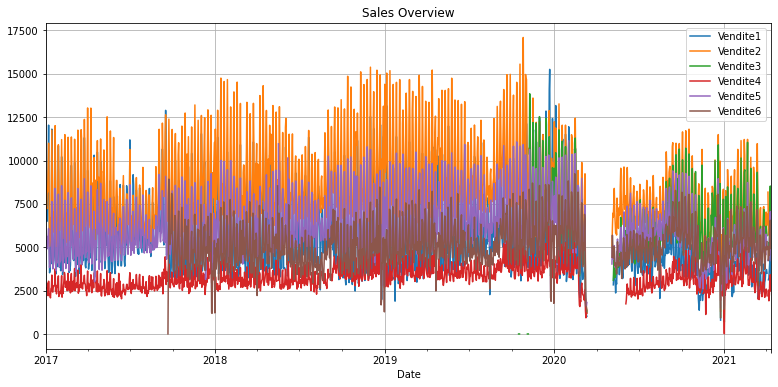

In [ ]:
ax = sales[['Vendite1', 'Vendite2' , 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6']].plot(figsize=(13,6), title = 'Sales Overview').grid()

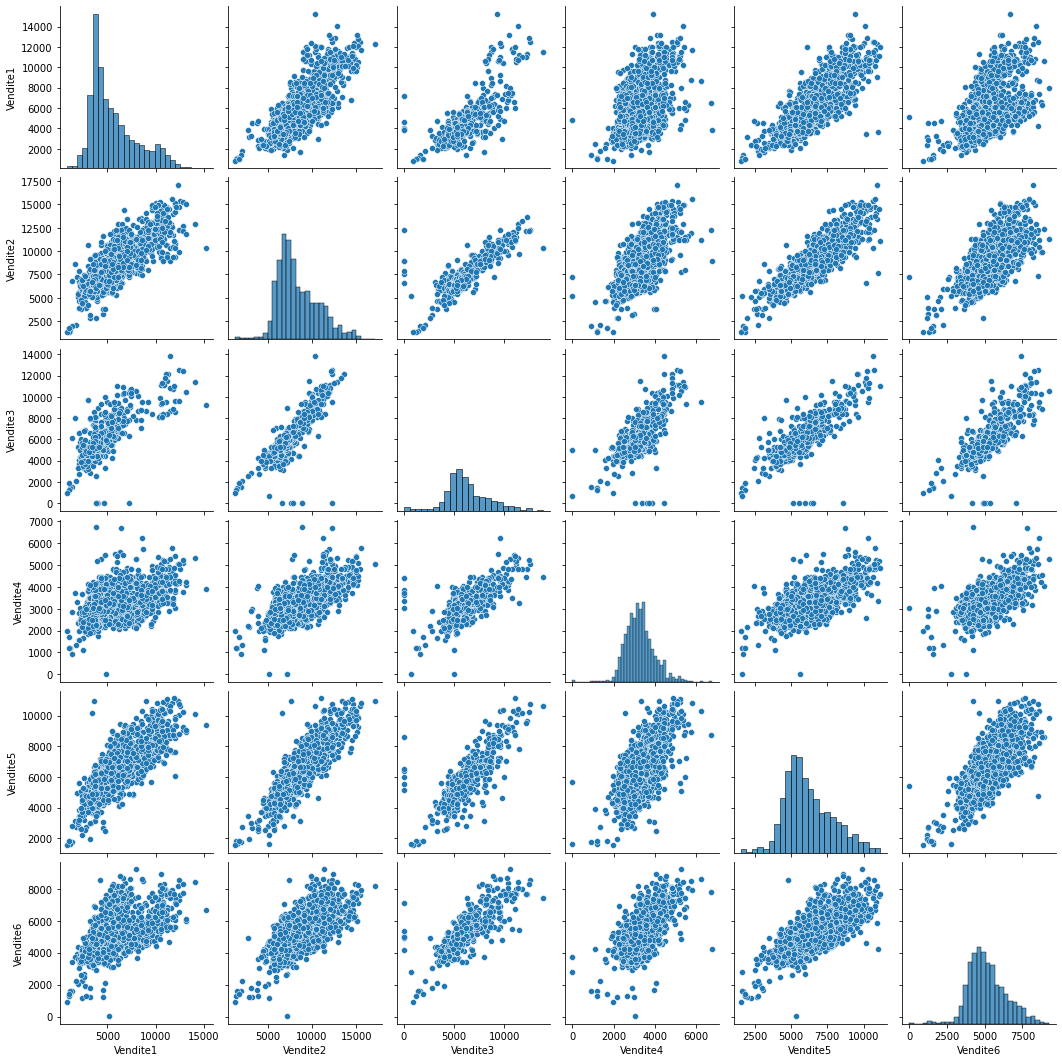

In [ ]:
sns.pairplot(sales[['Vendite1', 'Vendite2' , 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6']])

Then we compute the correlation matrix between the series.

In [ ]:
corr_all = ds_risto[['Scontrini1','Vendite1', 'Scontrini2','Vendite2', 'Scontrini3','Vendite3',
                     'Scontrini4','Vendite4','Scontrini5','Vendite5', 'Scontrini6','Vendite6']].corr()
corr_sal = sales[['Vendite1', 'Vendite2' , 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6']].corr()
corr_bil = receipts.corr()

In [ ]:
def CorrMtx(df, dropDuplicates = True):

    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    sns.set_style(style = 'white')

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.color_palette("light:b", as_cmap=True)

    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, vmin = 0.35, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
    else:
        sns.heatmap(df, cmap=cmap, vmin = 0, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)

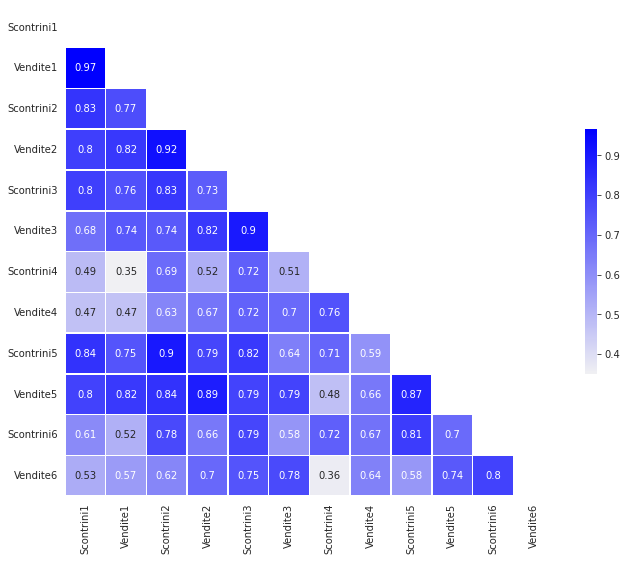

In [ ]:
CorrMtx(corr_all)

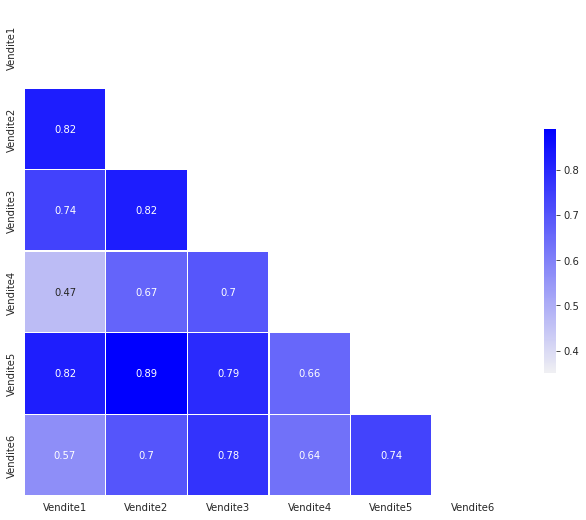

In [ ]:
CorrMtx(corr_sal)

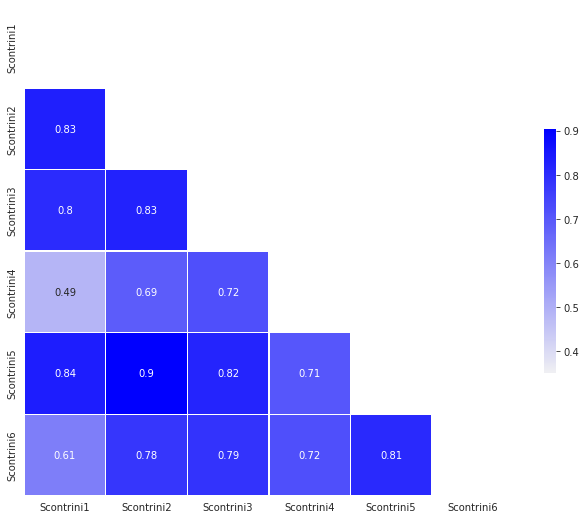

In [ ]:
CorrMtx(corr_bil)

We further explore the distribution of some of the time series. We chose time series 4 and 5 as a result of the clustering implemented later.

In [ ]:
sales_NoNa = ds_risto[["Vendite4", "Vendite5", "WeekDay", "Month", "Year"]].dropna()
sales_NoNa.head()

Vendite4  Vendite5  WeekDay  Month  Year
Date                                                
2017-01-02   2621.02   5388.64        1      1  2017
2017-01-03   2656.17   4973.78        2      1  2017
2017-01-04   2595.82   4911.55        3      1  2017
2017-01-05   2926.33   5622.54        4      1  2017
2017-01-06   2206.11   5678.27        5      1  2017

In [ ]:
sales_NoNa["Sales_Mean"] = (sales_NoNa["Vendite4"] + sales_NoNa["Vendite5"])/2

The following procedure has the goal to create the boxplot of the sales grouped by weekday. The same procedure has been repeated for month and year.

In [ ]:
WDay1 = sales_NoNa[sales_NoNa["WeekDay"] == 1]["Sales_Mean"]
WDay2 = sales_NoNa[sales_NoNa["WeekDay"] == 2]["Sales_Mean"]
WDay3 = sales_NoNa[sales_NoNa["WeekDay"] == 3]["Sales_Mean"]
WDay4 = sales_NoNa[sales_NoNa["WeekDay"] == 4]["Sales_Mean"]
WDay5 = sales_NoNa[sales_NoNa["WeekDay"] == 5]["Sales_Mean"]
WDay6 = sales_NoNa[sales_NoNa["WeekDay"] == 6]["Sales_Mean"]
WDay7 = sales_NoNa[sales_NoNa["WeekDay"] == 7]["Sales_Mean"]

WDay1

Date
2017-01-02    4004.830
2017-01-09    3080.570
2017-01-16    3083.075
2017-01-23    3225.110
2017-01-30    3106.620
                ...   
2021-03-08    3441.270
2021-03-15    2594.215
2021-03-22    3206.490
2021-03-29    2923.150
2021-04-12    3628.640
Name: Sales_Mean, Length: 206, dtype: float64

In [ ]:
rd.shuffle(WDay1.copy())
rd.shuffle(WDay2.copy())
rd.shuffle(WDay3.copy())
rd.shuffle(WDay4.copy())
rd.shuffle(WDay5.copy())
rd.shuffle(WDay6.copy())
rd.shuffle(WDay7.copy())

WDay1

Date
2017-01-02    4004.830
2017-01-09    3080.570
2017-01-16    3083.075
2017-01-23    3225.110
2017-01-30    3106.620
                ...   
2021-03-08    3441.270
2021-03-15    2594.215
2021-03-22    3206.490
2021-03-29    2923.150
2021-04-12    3628.640
Name: Sales_Mean, Length: 206, dtype: float64

In [ ]:
print("Lun: ",len(WDay1))
print("Mar: ",len(WDay2))
print("Mer: ",len(WDay3))
print("Gio: ",len(WDay4))
print("Ven: ",len(WDay5))
print("Sab: ",len(WDay6))
print("Dom: ",len(WDay7))

Lun:  206
Mar:  204
Mer:  206
Gio:  208
Ven:  209
Sab:  209
Dom:  205


In [ ]:
WDay1 = WDay1[:204].reset_index()["Sales_Mean"]
WDay2 = WDay2.reset_index()["Sales_Mean"]
WDay3 = WDay3[:204].reset_index()["Sales_Mean"]
WDay4 = WDay4[:204].reset_index()["Sales_Mean"]
WDay5 = WDay5[:204].reset_index()["Sales_Mean"]
WDay6 = WDay6[:204].reset_index()["Sales_Mean"]
WDay7 = WDay7[:204].reset_index()["Sales_Mean"]

We needed to have a dataset with the same length for each day, so we randomly sampled to have the same values as the weekday with less values.

In [ ]:
WDay_df = {"Lun":WDay1, "Mar":WDay2, "Mer":WDay3, "Gio":WDay4, "Ven":WDay5, "Sab":WDay6, "Dom":WDay7}
WDay = pd.DataFrame(data=WDay_df)
WDay

Lun       Mar       Mer       Gio       Ven       Sab       Dom
0    4004.830  3814.975  3753.685  4274.435  3942.190  4561.985  3604.200
1    3080.570  3130.720  3080.820  3458.445  4382.400  5513.995  4563.395
2    3083.075  3444.830  3511.765  4110.285  4700.435  6070.800  4419.440
3    3225.110  3279.675  3386.470  3804.550  4739.300  5702.550  4405.110
4    3106.620  3328.535  3306.185  3281.490  4517.925  5947.605  3987.070
..        ...       ...       ...       ...       ...       ...       ...
199  3388.705  3646.635  4039.375  4361.815  5249.860  6107.905  5125.940
200  3702.530  2916.415  3792.145  4305.275  5267.040  6357.565  3891.915
201  3441.270  3331.370  3964.400  4470.830  5511.135  7070.935  4535.775
202  2594.215  3559.545  3123.135  3972.510  5413.130  5806.410  3536.090
203  3206.490  3423.560  3602.555  3920.865  4795.165  4995.165  3816.585

[204 rows x 7 columns]

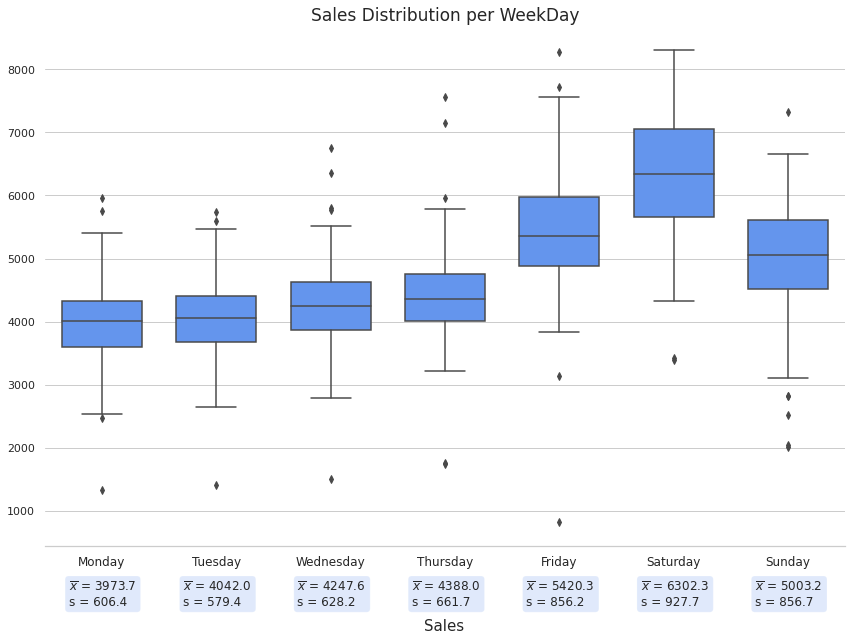

In [ ]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12,9))

g = sns.boxplot(data=WDay, width=0.7)

c = "cornflowerblue"

# Titles and labels
plt.title("Sales Distribution per WeekDay", fontsize=17)

# X tick-labels
xvalues = ["Monday","Tuesday","Wednesday",
           "Thursday", "Friday", "Saturday", "Sunday"] 

# set xvalues as xtick values
plt.xticks(np.arange(7), xvalues, fontsize = 12)

# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)

textstr = "Sales"
g.text(2.82, -900, textstr, fontsize=15)

# Set colors of box plots 
palette= [c,c,c,c,c,c,c]
color_dict = dict(zip(xvalues, palette))
for i in range(0,7):
    mybox = g.artists[i]
    mybox.set_facecolor(c)

### Provide mean and standard deviation for each weekday ###   
# Text p1
mean = round(WDay['Lun'].mean(),1)
sd = round(WDay['Lun'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(-0.29, -500, textstr, fontsize=12, bbox=props)

# Text p2
mean = round(WDay['Mar'].mean(),1)
sd = round(WDay['Mar'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(0.71, -500, textstr, fontsize=12, bbox=props)

# Text p3
mean = round(WDay['Mer'].mean(),1)
sd = round(WDay['Mer'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(1.71, -500, textstr, fontsize=12, bbox=props)

# Text p4
mean = round(WDay['Gio'].mean(),1)
sd = round(WDay['Gio'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(2.71, -500, textstr, fontsize=12, bbox=props) # 2 for y but covers diamond

# Text p5
mean = round(WDay['Ven'].mean(),1)
sd = round(WDay['Ven'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(3.71, -500, textstr, fontsize=12, bbox=props)

# Text p6
mean = round(WDay['Sab'].mean(),1)
sd = round(WDay['Sab'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(4.71, -500, textstr, fontsize=12, bbox=props)

# Text p7
mean = round(WDay['Dom'].mean(),1)
sd = round(WDay['Dom'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(5.71, -500, textstr, fontsize=12, bbox=props)

    
plt.tight_layout()
# plt.savefig('all_sat_boxplots.png', dpi=500)
plt.show()

We repeat the same process for month.

In [ ]:
Month1 = sales_NoNa[sales_NoNa["Month"] == 1]["Sales_Mean"]
Month2 = sales_NoNa[sales_NoNa["Month"] == 2]["Sales_Mean"]
Month3 = sales_NoNa[sales_NoNa["Month"] == 3]["Sales_Mean"]
Month4 = sales_NoNa[sales_NoNa["Month"] == 4]["Sales_Mean"]
Month5 = sales_NoNa[sales_NoNa["Month"] == 5]["Sales_Mean"]
Month6 = sales_NoNa[sales_NoNa["Month"] == 6]["Sales_Mean"]
Month7 = sales_NoNa[sales_NoNa["Month"] == 7]["Sales_Mean"]
Month8 = sales_NoNa[sales_NoNa["Month"] == 8]["Sales_Mean"]
Month9 = sales_NoNa[sales_NoNa["Month"] == 9]["Sales_Mean"]
Month10 = sales_NoNa[sales_NoNa["Month"] == 10]["Sales_Mean"]
Month11 = sales_NoNa[sales_NoNa["Month"] == 11]["Sales_Mean"]
Month12 = sales_NoNa[sales_NoNa["Month"] == 12]["Sales_Mean"]

In [ ]:
rd.shuffle(Month1.copy())
rd.shuffle(Month2.copy())
rd.shuffle(Month3.copy())
rd.shuffle(Month4.copy())
rd.shuffle(Month5.copy())
rd.shuffle(Month6.copy())
rd.shuffle(Month7.copy())
rd.shuffle(Month8.copy())
rd.shuffle(Month9.copy())
rd.shuffle(Month10.copy())
rd.shuffle(Month11.copy())
rd.shuffle(Month12.copy())

In [ ]:
print("Gen: ",len(Month1))
print("Feb: ",len(Month2))
print("Mar: ",len(Month3))
print("Apr: ",len(Month4))
print("Mag: ",len(Month5))
print("Giu: ",len(Month6))
print("Lug: ",len(Month7))
print("Ago: ",len(Month8))
print("Set: ",len(Month9))
print("Ott: ",len(Month10))
print("Nov: ",len(Month11))
print("Dic: ",len(Month12))


Gen:  151
Feb:  141
Mar:  135
Apr:  89
Mag:  91
Giu:  118
Lug:  124
Ago:  119
Set:  120
Ott:  124
Nov:  119
Dic:  116


In [ ]:
Month1 = Month1[:89].reset_index()["Sales_Mean"]
Month4 = Month4.reset_index()["Sales_Mean"]
Month2 = Month2[:89].reset_index()["Sales_Mean"]
Month3 = Month3[:89].reset_index()["Sales_Mean"]
Month5 = Month5[:89].reset_index()["Sales_Mean"]
Month6 = Month6[:89].reset_index()["Sales_Mean"]
Month7 = Month7[:89].reset_index()["Sales_Mean"]
Month8 = Month8[:89].reset_index()["Sales_Mean"]
Month9 = Month9[:89].reset_index()["Sales_Mean"]
Month10 = Month10[:89].reset_index()["Sales_Mean"]
Month11 = Month11[:89].reset_index()["Sales_Mean"]
Month12 = Month12[:89].reset_index()["Sales_Mean"]

In [ ]:
Month_df = {"Gen":Month1, "Feb":Month2, "Mar":Month3, "Apr":Month4, "Mag":Month5, "Giu":Month6, "Lug":Month7,
           "Ago":Month8, "Set":Month9, "Ott":Month10, "Nov":Month11, "Dic":Month12}
Month = pd.DataFrame(data=Month_df)
Month

Gen       Feb       Mar  ...       Ott       Nov       Dic
0   4004.830  3306.185  3675.685  ...  4699.480  4719.410  5917.005
1   3814.975  3281.490  3773.385  ...  3582.775  3738.985  6167.635
2   3753.685  4517.925  4536.510  ...  3716.860  4588.695  4607.300
3   4274.435  5947.605  5498.140  ...  3715.005  5740.605  3711.845
4   3942.190  3987.070  4377.840  ...  4055.275  4167.815  3948.100
..       ...       ...       ...  ...       ...       ...       ...
84  7661.665  8007.980  7051.510  ...  4842.455  4305.125  5477.285
85  5373.245  5591.510  6426.915  ...  4385.900  4612.880  5753.155
86  3946.555  4107.485  4296.735  ...  6638.935  4489.285  2925.505
87  4033.935  4292.685  4236.510  ...  7995.700  4713.235  3412.700
88  3707.905  4623.565  4608.555  ...  7322.525  6456.295  3409.995

[89 rows x 12 columns]

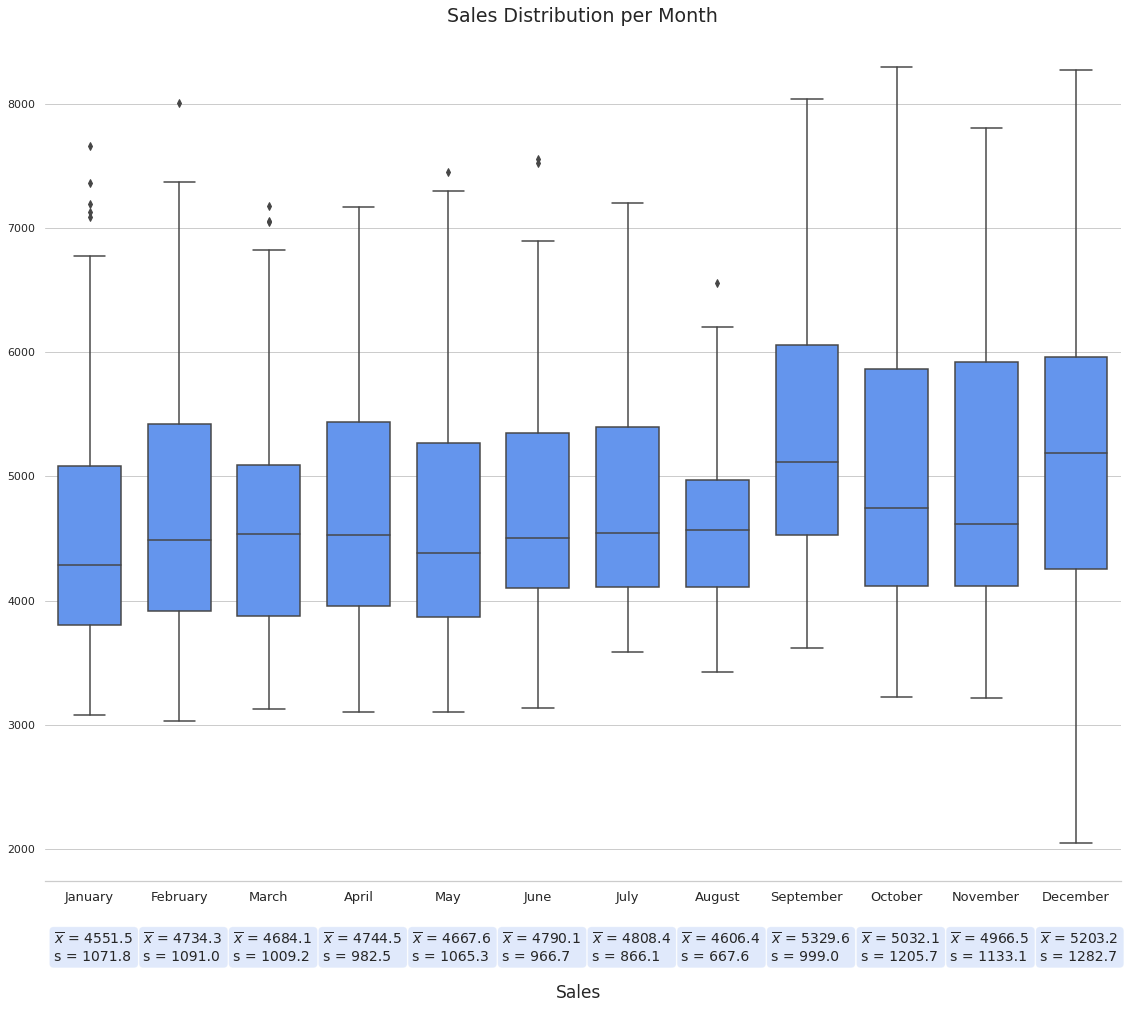

In [ ]:
sns.set(style='whitegrid')

x_med_v = -0.40
y = 1100

fig, ax = plt.subplots(figsize=(16,14))
g = sns.boxplot(data=Month, width=0.7)

# Titles and labels
plt.title("Sales Distribution per Month", fontsize=19)

for i in range(0,12):
    mybox = g.artists[i]
    mybox.set_facecolor(c)

# X tick-labels
xvalues = ["January","February","March",
           "April", "May", "June", "July", "August",
           "September", "October", "November", "December"] 

# set xvalues as xtick values
plt.xticks(np.arange(12), xvalues, fontsize = 13)

# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)

textstr = "Sales"
g.text(x_med_v+5.6, 800, textstr, fontsize=17)

### Provide mean and standard deviation for each month ###   
# Text p1
mean = round(Month['Gen'].mean(),1)
sd = round(Month['Gen'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v, y, textstr, fontsize=14, bbox=props)

# Text p2
mean = round(Month['Feb'].mean(),1)
sd = round(Month['Feb'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+1, y, textstr, fontsize=14, bbox=props)

# Text p3
mean = round(Month['Mar'].mean(),1)
sd = round(Month['Mar'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+2, y, textstr, fontsize=14, bbox=props)

# Text p4
mean = round(Month['Apr'].mean(),1)
sd = round(Month['Apr'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+3, y, textstr, fontsize=14, bbox=props) 

# Text p5
mean = round(Month['Mag'].mean(),1)
sd = round(Month['Mag'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+4, y, textstr, fontsize=14, bbox=props)

# Text p6
mean = round(Month['Giu'].mean(),1)
sd = round(Month['Giu'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+5, y, textstr, fontsize=14, bbox=props)

# Text p7
mean = round(Month['Lug'].mean(),1)
sd = round(Month['Lug'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+6, y, textstr, fontsize=14, bbox=props)

# Text p8
mean = round(Month['Ago'].mean(),1)
sd = round(Month['Ago'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+7, y, textstr, fontsize=14, bbox=props)

# Text p9
mean = round(Month['Set'].mean(),1)
sd = round(Month['Set'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+8, y, textstr, fontsize=14, bbox=props)

# Text p10
mean = round(Month['Ott'].mean(),1)
sd = round(Month['Ott'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+9, y, textstr, fontsize=14, bbox=props)

# Text p11
mean = round(Month['Nov'].mean(),1)
sd = round(Month['Nov'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+10, y, textstr, fontsize=14, bbox=props)

# Text p12
mean = round(Month['Dic'].mean(),1)
sd = round(Month['Dic'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x_med_v+11, y, textstr, fontsize=14, bbox=props)
    
plt.tight_layout()
# plt.savefig('all_sat_boxplots.png', dpi=500)
plt.show()

We repeat the same process for eacc year. We exclude the 2021 to avoid biased representation having only few months available.

In [ ]:
Year17 = sales_NoNa[sales_NoNa["Year"] == 2017]["Sales_Mean"]
Year18 = sales_NoNa[sales_NoNa["Year"] == 2018]["Sales_Mean"]
Year19 = sales_NoNa[sales_NoNa["Year"] == 2019]["Sales_Mean"]
Year20 = sales_NoNa[sales_NoNa["Year"] == 2020]["Sales_Mean"]
#Year21 = sales_NoNa[sales_NoNa["Year"] == 2021]["Sales_Mean"]

In [ ]:
rd.shuffle(Year17.copy())
rd.shuffle(Year18.copy())
rd.shuffle(Year19.copy())
rd.shuffle(Year20.copy())
#rd.shuffle(Year21.copy())

In [ ]:
print("2017: ",len(Year17))
print("2018: ",len(Year18))
print("2019: ",len(Year19))
print("2020: ",len(Year20))
#print("2021: ",len(Year21))

2017:  359
2018:  351
2019:  359
2020:  278


In [ ]:
Year17 = Year17[:278].reset_index()["Sales_Mean"]
Year18 = Year18[:278].reset_index()["Sales_Mean"]
Year19 = Year19[:278].reset_index()["Sales_Mean"]
Year20 = Year20[:278].reset_index()["Sales_Mean"]
#Year21 = Year21.reset_index()["Sales_Mean"]

In [ ]:
Year_df = {"2017":Year17, "2018":Year18, "2019":Year19, "2020":Year20}
Year = pd.DataFrame(data=Year_df)
Year

2017      2018      2019      2020
0    4004.830  4187.480  5054.785  5441.785
1    3814.975  3991.130  4420.980  5948.385
2    3753.685  4336.515  5550.140  6636.720
3    4274.435  4950.895  6490.015  5954.725
4    3942.190  5294.055  5452.705  4852.425
..        ...       ...       ...       ...
273  4055.275  7190.250  7872.605  3181.555
274  4815.670  5677.310  5779.025  2828.550
275  6096.435  4339.580  4125.535  4317.265
276  4748.005  4173.115  4113.500  4843.885
277  3593.020  4209.050  4539.200  1755.360

[278 rows x 4 columns]

Text(2.74, 1.1, '$\\overline {x}$ = 4559.8 \ns = 1140.5')

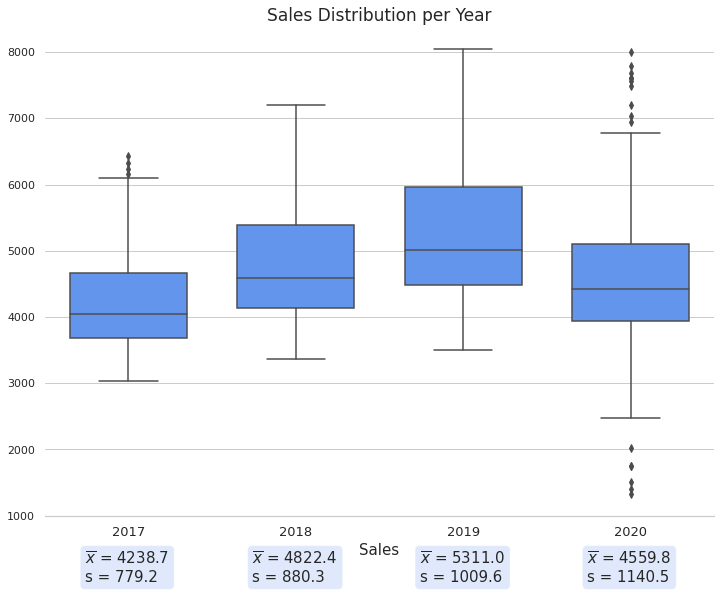

In [ ]:
sns.set(style='whitegrid')

x = -0.26

fig, ax = plt.subplots(figsize=(12,9))

g = sns.boxplot(data=Year, width=0.7)

# Titles and labels
plt.title("Sales Distribution per Year", fontsize=17)

plt.xlabel("Sales", fontsize=15)

palette= [c,c,c,c]
color_dict = dict(zip(xvalues, palette))
for i in range(0,4):
    mybox = g.artists[i]
    mybox.set_facecolor(color_dict[xvalues[i]])


# X tick-labels
xvalues = ["2017", "2018", "2019", "2020"] 

# set xvalues as xtick values
plt.xticks(np.arange(4), xvalues, fontsize=13)


# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)

### Provide mean and standard deviation for each year ###   
# Text p1
mean = round(Year['2017'].mean(),1)
sd = round(Year['2017'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x, 1.1, textstr, fontsize=15, bbox=props)

# Text p2
mean = round(Year['2018'].mean(),1)
sd = round(Year['2018'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x+1, 1.1, textstr, fontsize=15, bbox=props)

# Text p3
mean = round(Year['2019'].mean(),1)
sd = round(Year['2019'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x+2, 1.1, textstr, fontsize=15, bbox=props)

# Text p4
mean = round(Year['2020'].mean(),1)
sd = round(Year['2020'].std(),1)
textstr = "$\overline {x}$" + f" = {mean} \ns = {sd}"
props = dict(boxstyle='round', facecolor=c, alpha=0.2)
g.text(x+3, 1.1, textstr, fontsize=15, bbox=props) # 2 for y but covers diamond

#  2 Clustering

The high correlation between the variables highlighted the necessity to reduce the redundency of the results. Cluster analysis is useful to group the time series into clusters. We chose to implement the time series k-means algorithm to split the time series in k=2 clusters.

In [ ]:
!pip install tslearn

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
sales_T = sales[['Vendite1', 'Vendite2', 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6']].T
sales_T

Date      2017-01-01  2017-01-02  ...  2021-04-11  2021-04-12
Vendite1     7627.12     6987.16  ...     3413.91     4164.54
Vendite2     9409.06     7403.93  ...     6727.20     6343.96
Vendite3         NaN         NaN  ...     5278.47     5287.84
Vendite4         NaN     2621.02  ...     2475.71     3029.98
Vendite5     4841.05     5388.64  ...     4883.18     4227.30
Vendite6         NaN         NaN  ...     4923.76     5158.58

[6 rows x 1563 columns]

In [ ]:
inter = sales[['Vendite1', 'Vendite2', 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6', 'Holiday']].interpolate(method ='linear', limit_direction="Both")
inter_t = inter[['Vendite1', 'Vendite2', 'Vendite3', 'Vendite4', 'Vendite5', 'Vendite6']].T
#inter_df = pd.DataFrame(data = inter, columns = ['Vendite1','Vendite2','Vendite3','Vendite4','Vendite5','Vendite6'])
#inter_df = inter_df.set_index(Date_Fixed)
inter['Holiday']

Date
2017-01-01    1
2017-01-02    1
2017-01-03    1
2017-01-04    1
2017-01-05    1
             ..
2021-04-08    1
2021-04-09    1
2021-04-10    1
2021-04-11    1
2021-04-12    1
Freq: D, Name: Holiday, Length: 1563, dtype: int64

In [ ]:
k_means = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5, random_state=0)
y_pred = k_means.fit_predict(inter_t)
y_pred

array([0, 0, 1, 1, 0, 1])

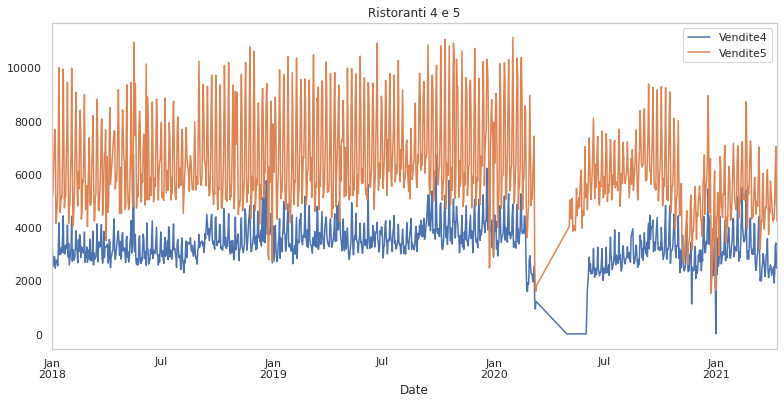

In [ ]:
ax = inter[['Vendite4', 'Vendite5']]['01-01-2018':'31-12-2021'].plot(figsize=(13,6), title = 'Ristoranti 4 e 5').grid()

# 3 Analisi esplorativa per l'applicazione dei modelli


---
Given the clustering results, it was decided to analyze the sales of restaurants 4 and 5



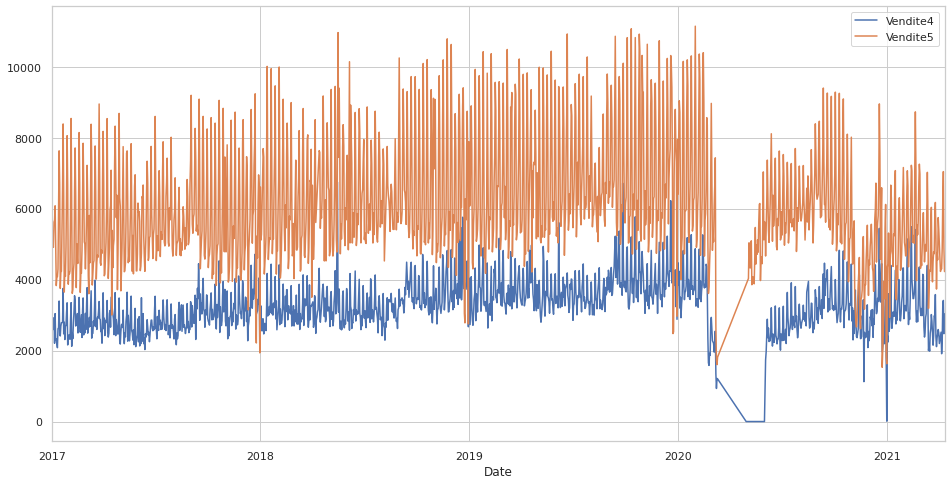

In [ ]:
inter[['Vendite4', 'Vendite5']].plot(figsize=(16,8))

We import the libraries for the SARIMAX and ARIMA models.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
#!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
inter.loc['2020-02-06': '2020-05-06']

Vendite1      Vendite2  ...     Vendite6  Holiday
Date                                    ...                      
2020-02-06   4308.460000   6651.380000  ...  6312.480000        0
2020-02-07   6150.330000  11486.430000  ...  8187.040000        0
2020-02-08  10467.550000  11329.720000  ...  7895.190000        0
2020-02-09  10653.560000  10992.090000  ...  6976.120000        0
2020-02-10   3140.670000   5856.180000  ...  4916.960000        0
...                  ...           ...  ...          ...      ...
2020-05-02   2673.367018   4823.107778  ...  4307.190741        0
2020-05-03   2705.305614   4889.963889  ...  4365.050370        0
2020-05-04   2737.244211   4956.820000  ...  4422.910000        0
2020-05-05   2769.182807   6123.280000  ...  5692.420000        0
2020-05-06   2801.121404   6961.500000  ...  5079.530000        0

[91 rows x 7 columns]

We select the 3 years from 22-02-2017 to 22-02-2020.

In [ ]:
data = inter.iloc[52:1148]

In [ ]:
len(data)

1096

In [ ]:
data.head(10)

Vendite1  Vendite2  Vendite3  Vendite4  Vendite5  Vendite6  Holiday
Date                                                                           
2017-02-22   3646.42   6483.67      0.23   3009.98   4178.84      4.54        0
2017-02-23   3995.17   6467.24      0.23   2369.06   4827.18      4.54        0
2017-02-24   5290.64   8543.29      0.23   3134.82   6299.21      4.54        0
2017-02-25   9718.05  11357.02      0.23   3484.04   7844.38      4.54        0
2017-02-26   7810.37   9391.22      0.23   2442.50   6662.84      4.54        0
2017-02-27   6008.40   6012.91      0.23   2676.27   5062.60      4.54        0
2017-02-28   4675.63   6888.06      0.23   2496.48   5004.80      4.54        0
2017-03-01   4383.02   6808.34      0.23   3048.72   4302.65      4.54        0
2017-03-02   4234.33   6312.61      0.23   2599.55   4947.22      4.54        0
2017-03-03   5350.82   8561.83      0.23   3276.31   5796.71      4.54        0

# 4 **SARIMA** del ristorante 4
---

We plot the series for a qualitative exploration.

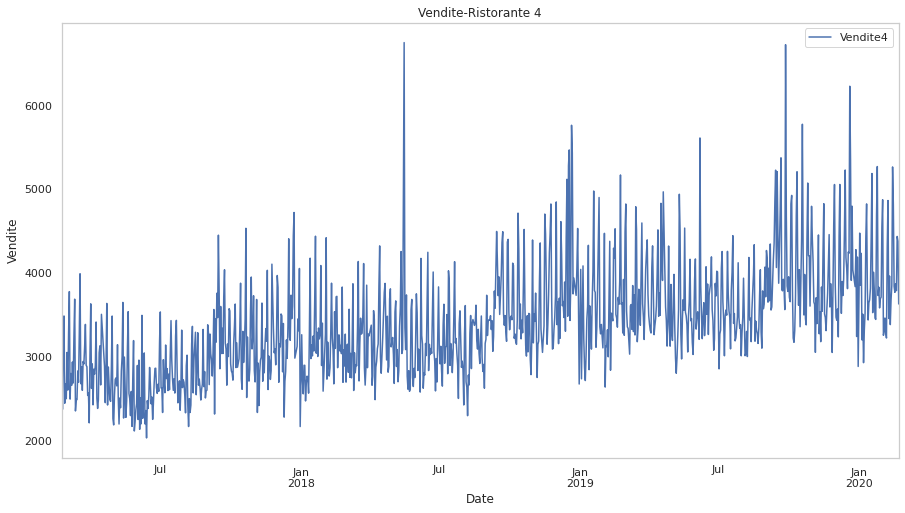

In [ ]:
ax = data['Vendite4'].plot(figsize=(15,8), legend=True, title='Vendite-Ristorante 4');
ax.set(ylabel='Vendite')
plt.grid()

The series seems not to be stationary, we check with the adfuller-test.


In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller(data['Vendite4'])
#p value=0.17 we can't reject HO

(-2.2805821275066758,
 0.17830711676923544,
 20,
 1075,
 {'1%': -3.4364476591811033,
  '10%': -2.5682035004867494,
  '5%': -2.864232347211692},
 15952.829852614697)

... the test confirmed our hypothesis of a non-stationary time series.

Then We decompose the time series.

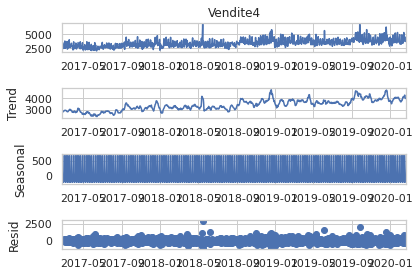

In [ ]:
result = seasonal_decompose(data['Vendite4'])
result.plot();

Analyzing a month we see a weekly seasonality.

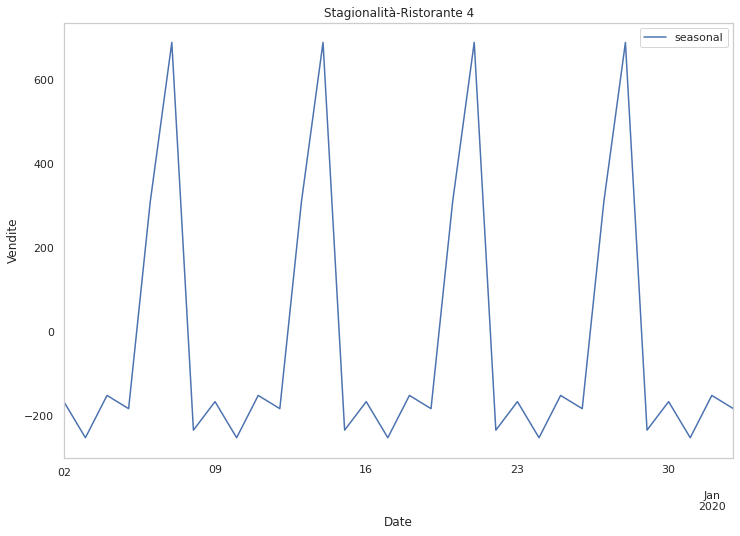

In [ ]:
ax = result.seasonal.plot(figsize=(12,8), xlim=('2019-12-02','2020-01-02'), legend=True, title='Stagionalità-Ristorante 4');
ax.set(ylabel='Vendite')
plt.grid()

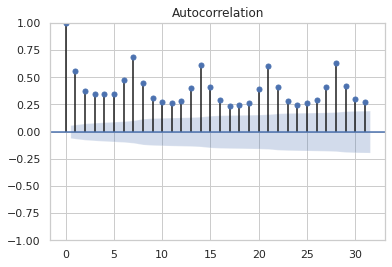

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Vendite4']);

We have further confirmation of a weekly seasonality.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


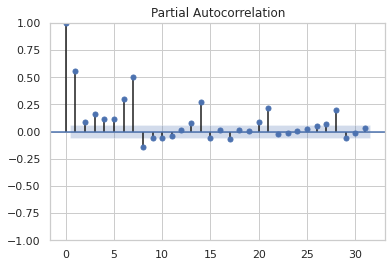

In [ ]:
plot_pacf(data['Vendite4']);

In [ ]:
auto_arima(data['Vendite4'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -8127.989
Date:                             Thu, 20 Jan 2022   AIC                          16271.978
Time:                                     15:45:15   BIC                          16311.966
Sample:                                          0   HQIC                         16287.109
                                            - 1096                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -12.0074      3.702     -3.244      0.001     -19.263      -4.752
ar.L1         -0.5878      0.020    -28.852      0.000      -0.628      -0.548
ar.L2         -0.4760      0.027    -17.607      0.000      -0.529      -0.423
ar.L3         -0.2805      0.031     -9.001      0.000      -0.342      -0.219
ar.L4         -0.1176      0.032     -3.678      0.000      -0.180      -0.055
ar.S.L7        0.9724      0.009    106.680      0.000       0.955       0.990
ma.S.L7       -0.7918      0.034    -23.337      0.000      -0.858      -0.725
sigma2      1.828e+05   5070.566     36.057      0.000    1.73e+05    1.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              1650.01
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We look for ARIMA parameters.

## 4.1 Performance modello

In [ ]:
len(data)

1096

We select a test set of 90 days and we split the data between training set and test set.

In [ ]:
len(data)-90

1006

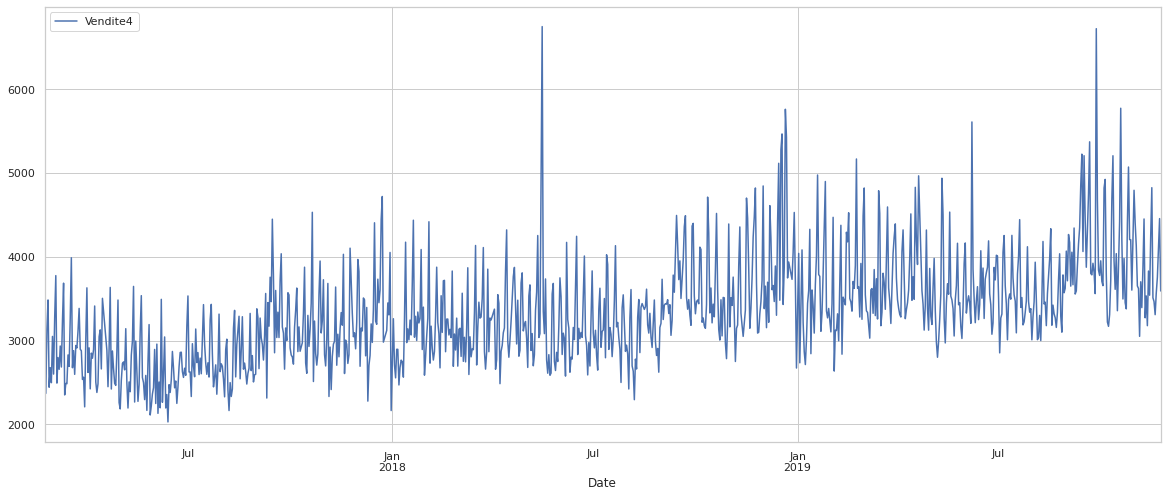

In [ ]:
train=data.iloc[:1006]
test=data.iloc[1006:]
train['Vendite4'].plot(figsize=(20,8), legend=True)

We define the model with the prevously obtained parameter.

In [ ]:
modello=SARIMAX(train['Vendite4'], order=(4,1,0), seasonal_order=(1,0,[1],7))
risultato = modello.fit()
risultato.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite4   No. Observations:                 1006
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -7422.031
Date:                             Thu, 20 Jan 2022   AIC                          14858.062
Time:                                     15:45:21   BIC                          14892.451
Sample:                                 02-22-2017   HQIC                         14871.129
                                      - 11-24-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5873      0.021    -27.498      0.000      -0.629      -0.545
ar.L2         -0.4617      0.027    -16.924      0.000      -0.515      -0.408
ar.L3         -0.2859      0.032     -9.022      0.000      -0.348      -0.224
ar.L4         -0.1227      0.031     -3.908      0.000      -0.184      -0.061
ar.S.L7        1.0000   3.73e-05   2.68e+04      0.000       1.000       1.000
ma.S.L7       -0.9990      0.030    -33.563      0.000      -1.057      -0.941
sigma2       1.77e+05   1.67e-07   1.06e+12      0.000    1.77e+05    1.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              1649.00
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.39e+26. Standard errors may be unstable.
"""

In [ ]:
start = len(train)
end= len(train) + len(test) -1

We forecast on the test set and we compare it to the actual data.

In [ ]:
predizioni = risultato.predict(start, end,  typ='Levels').rename('Predizione vendite 4')

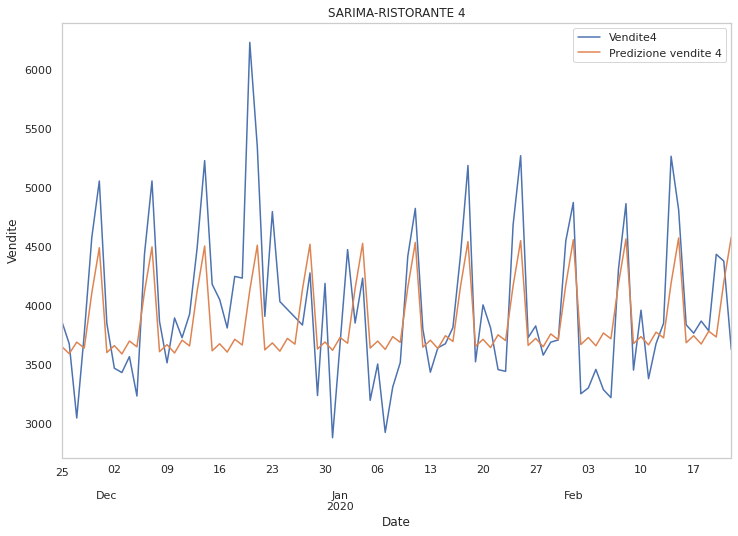

In [ ]:
ax = test['Vendite4'].plot(figsize=(12,8), legend=True, title='SARIMA-RISTORANTE 4', grid=True)
ax.set(ylabel='Vendite')
predizioni.plot(legend= True)
plt.grid()

**Performance Evaluation**

We calculate the Root Mean Square Error (RMSE).

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
errore = rmse(predizioni, test['Vendite4'])
errore

462.2460416799558

In [ ]:
test['Vendite4'].mean()

3984.299444444444

*We observe that the root mean square error is smaller than the average of the test set, so we can say that our performance is good*

## 4.2 Forecasting


We now fit the since the model offers quite good performance

In [ ]:
modello=SARIMAX(data['Vendite4'], order=(4,1,0), seasonal_order=(1,0,[1],7))
res = modello.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite4   No. Observations:                 1096
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -8089.349
Date:                             Thu, 20 Jan 2022   AIC                          16192.698
Time:                                     15:45:26   BIC                          16227.687
Sample:                                 02-22-2017   HQIC                         16205.938
                                      - 02-22-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5830      0.017    -33.372      0.000      -0.617      -0.549
ar.L2         -0.4675      0.022    -21.002      0.000      -0.511      -0.424
ar.L3         -0.2811      0.026    -11.003      0.000      -0.331      -0.231
ar.L4         -0.1222      0.025     -4.867      0.000      -0.171      -0.073
ar.S.L7        1.0000   2.23e-05   4.48e+04      0.000       1.000       1.000
ma.S.L7       -0.9991      0.024    -41.538      0.000      -1.046      -0.952
sigma2      1.481e+05   1.55e-07   9.55e+11      0.000    1.48e+05    1.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):              1463.88
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+26. Standard errors may be unstable.
"""

And then implement the forecasting for 90 days with 95%

In [ ]:
y= res.get_forecast(90)
predictions = y.predicted_mean
confidenza = y.conf_int(0.05)
confidenza
confidenza.rename(columns={'lower Vendite4': 'lower_Vendite4', 'upper Vendite4': 'upper_Vendite4'}, inplace=True)
confidenza

lower_Vendite4  upper_Vendite4
2020-02-23     2699.834401     4212.608705
2020-02-24     2869.100269     4508.157011
2020-02-25     2695.294850     4391.803393
2020-02-26     2644.137067     4423.696553
2020-02-27     2517.139149     4405.828039
...                    ...             ...
2020-05-18      578.821581     6648.263116
2020-05-19      475.303083     6580.621920
2020-05-20      560.569929     6701.649673
2020-05-21      512.987942     6689.619841
2020-05-22      984.460392     7196.484528

[90 rows x 2 columns]

In [ ]:
previ =  pd.DataFrame(predictions)
previ = previ.rename(columns={'predicted_mean': 'Previsione Sarima'})
previ = previ.loc[:].squeeze()

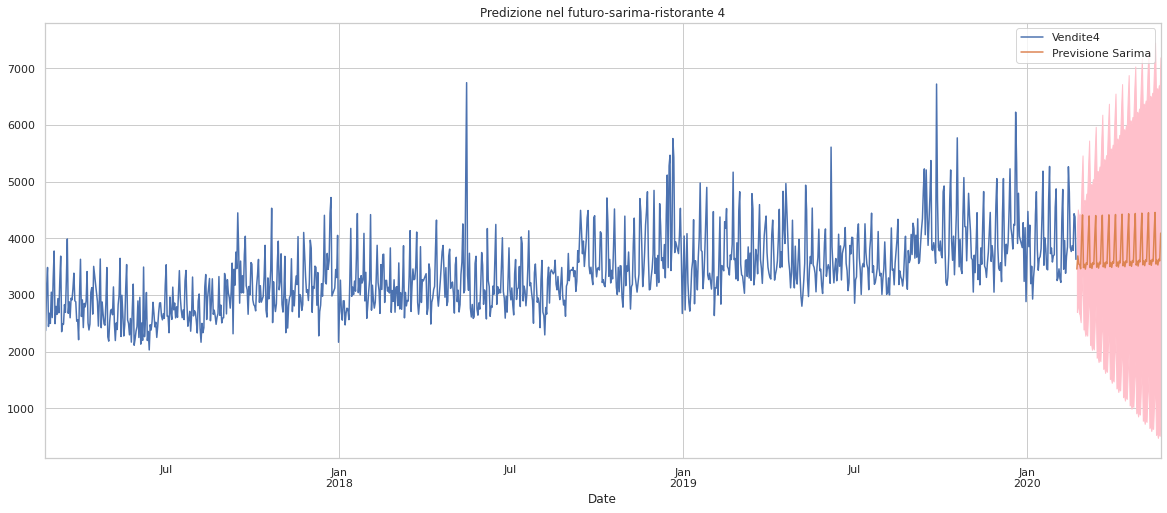

In [ ]:
data['Vendite4'].plot(figsize=(20,8), legend=True)
pred_plot= previ.plot(legend=True, title='Predizione nel futuro-sarima-ristorante 4')
pred_plot.fill_between(confidenza.index, confidenza['lower_Vendite4'], confidenza['upper_Vendite4'], color='pink')

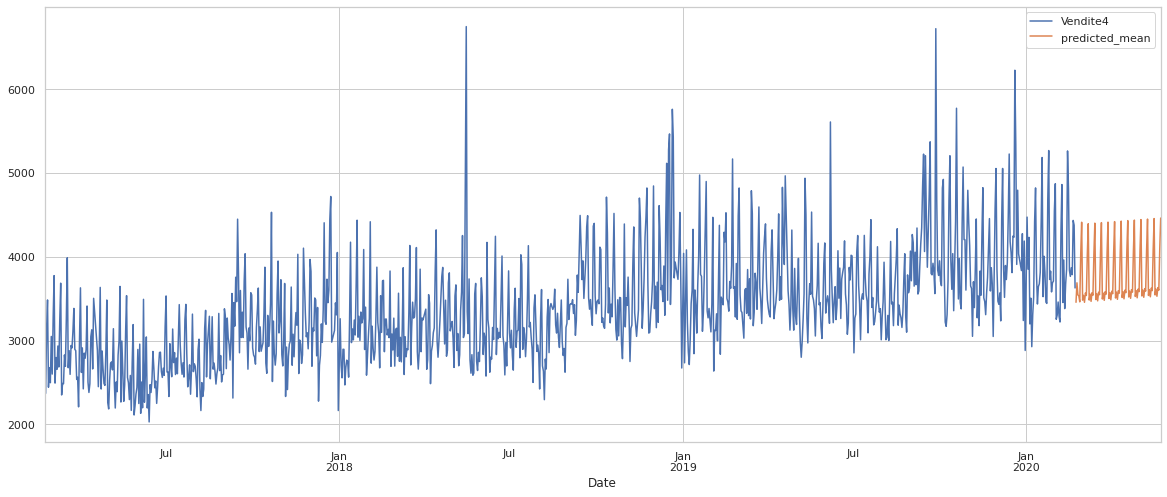

In [ ]:
predizione_nel_futuro = res.predict(len(data), len(data)+90, typ='levels')
data['Vendite4'].plot(figsize=(20,8), legend=True)
predizione_nel_futuro.plot(legend=True)

# 5 **SARIMA** ristorante 5
---





We plot the series for a qualitative exploration.

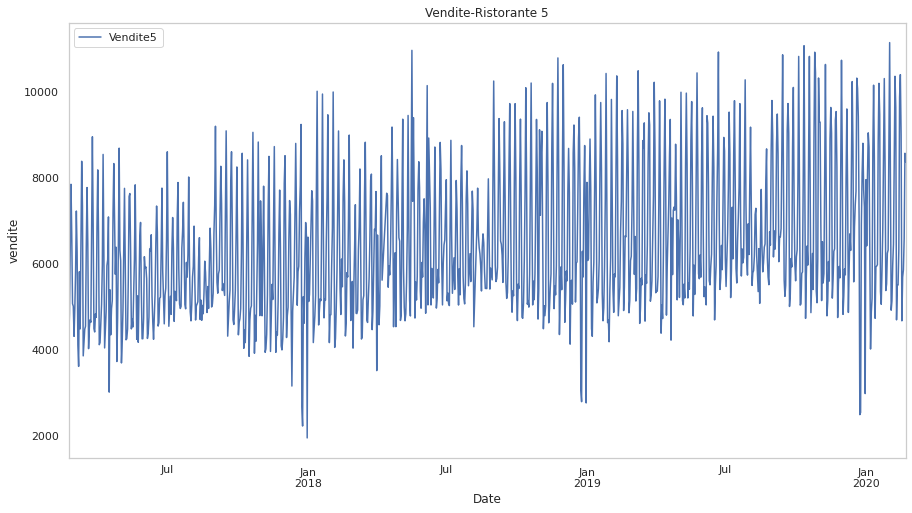

In [ ]:
ax = data['Vendite5'].plot(figsize=(15,8), legend=True, title='Vendite-Ristorante 5')
ax.set(ylabel='vendite')
plt.grid()

The series seems not to be stationary, we check with the adfuller-test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller(data['Vendite5'])
#p value=0.17 we can't reject HO

(-2.5359243026992555,
 0.10697638665955012,
 22,
 1073,
 {'1%': -3.436459052172655,
  '10%': -2.568206176974609,
  '5%': -2.864237372528562},
 17491.022642172175)

... the test confirmed our hypothesis of a non-stationary time series.

Then We decompose the time series.

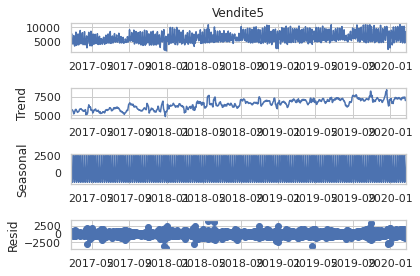

In [ ]:
result = seasonal_decompose(data['Vendite5'])
result.plot();

Analyzing a month we see a weekly seasonality.

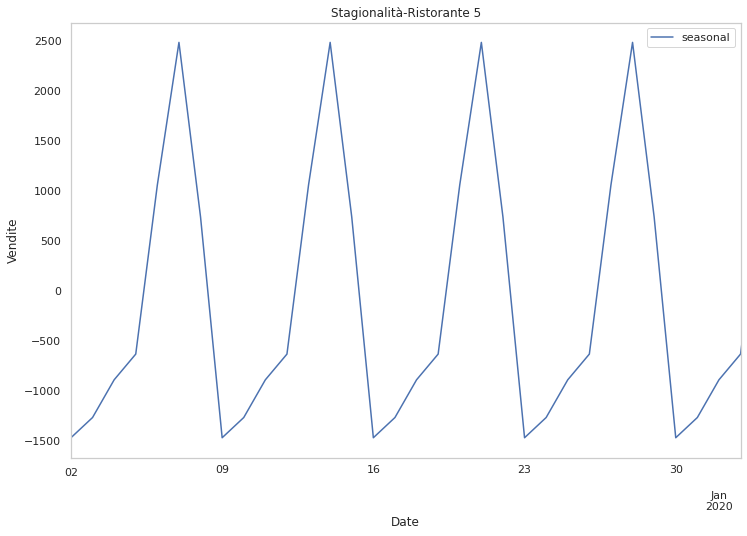

In [ ]:
ax = result.seasonal.plot(figsize=(12,8), xlim=('2019-12-02','2020-01-02'), legend=True, title='Stagionalità-Ristorante 5');
ax.set(ylabel='Vendite')
plt.grid()

We have further confirmation of a weekly seasonality.

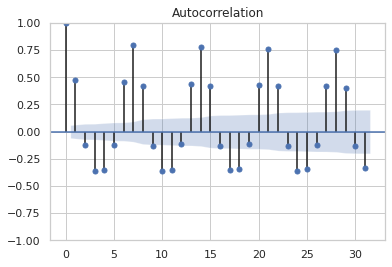

In [ ]:
plot_acf(data['Vendite5']);

We look for the ARIMA parameters

In [ ]:
auto_arima(data['Vendite5'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -9077.043
Date:                             Thu, 20 Jan 2022   AIC                          18164.087
Time:                                     15:46:33   BIC                          18189.079
Sample:                                          0   HQIC                         18173.544
                                            - 1096                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1005      2.901      0.035      0.972      -5.585       5.786
ar.L1         -0.3285      0.019    -17.403      0.000      -0.366      -0.292
ar.S.L7        0.9872      0.003    309.704      0.000       0.981       0.993
ma.S.L7       -0.8420      0.017    -49.055      0.000      -0.876      -0.808
sigma2      8.245e+05   1.77e+04     46.614      0.000     7.9e+05    8.59e+05
===================================================================================
Ljung-Box (L1) (Q):                  15.25   Jarque-Bera (JB):              1430.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.31
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5.1 Performance modello

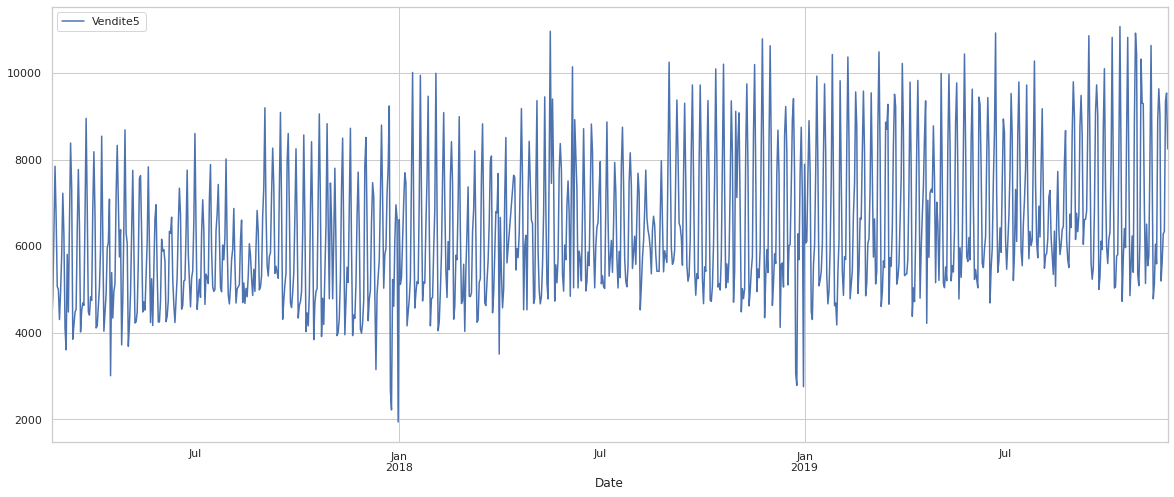

In [ ]:
train['Vendite5'].plot(figsize=(20,8), legend=True);

We define the model with the prevously obtained parameter.

In [ ]:
modello=SARIMAX(train['Vendite5'], order=(1,1,0), seasonal_order=(1,0,[1],7), enforce_invertibility=False)
risultato = modello.fit()
risultato.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite5   No. Observations:                 1006
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -8301.060
Date:                             Thu, 20 Jan 2022   AIC                          16610.119
Time:                                     15:46:36   BIC                          16629.770
Sample:                                 02-22-2017   HQIC                         16617.586
                                      - 11-24-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3559      0.020    -18.051      0.000      -0.394      -0.317
ar.S.L7        0.9999   9.49e-05   1.05e+04      0.000       1.000       1.000
ma.S.L7       -0.9444      0.009   -108.763      0.000      -0.961      -0.927
sigma2       7.75e+05   5.69e-09   1.36e+14      0.000    7.75e+05    7.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.38   Jarque-Bera (JB):              1380.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.43
Prob(H) (two-sided):                  0.49   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+29. Standard errors may be unstable.
"""

We forecast on the test set and we compare it to the actual data.

In [ ]:
predizioni_rist_5 = risultato.predict(start, end,  typ='Levels').rename('Predizione vendite 5')

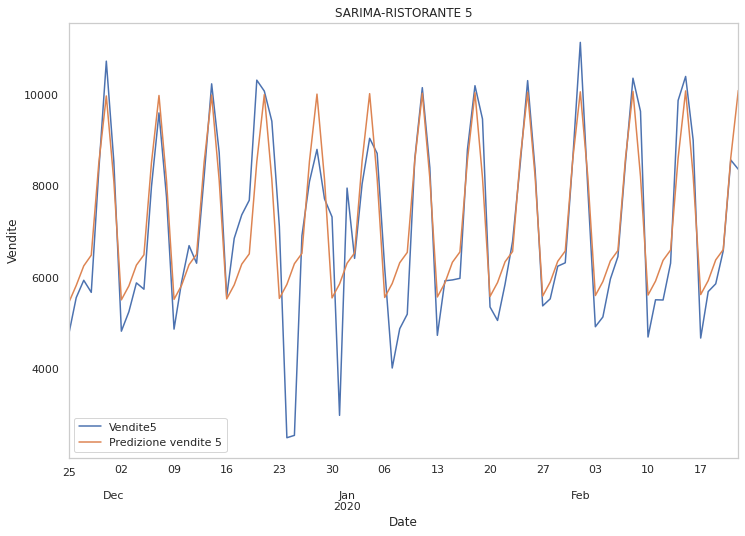

In [ ]:
ax = test['Vendite5'].plot(figsize=(12,8), legend=True, title='SARIMA-RISTORANTE 5', grid=True)
ax.set(ylabel='Vendite')
predizioni_rist_5.plot(legend= True)
plt.grid()

**Performance Evaluation**

We calculate the Root Mean Square Error (RMSE).

In [ ]:
errore = rmse(predizioni_rist_5, test['Vendite5'])
errore

969.5902134532628

In [ ]:
test['Vendite5'].mean()

7114.990111111112

*We observe that the root mean square error is smaller than the average of the test set, so we can say that our performance is good*



## 5.2 Forecasting

We now fit the since the model offers quite good performance

In [ ]:
modello=SARIMAX(data['Vendite5'], order=(1,1,0), seasonal_order=(1,0,[1],7))
res = modello.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite5   No. Observations:                 1096
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -9084.675
Date:                             Thu, 20 Jan 2022   AIC                          18177.351
Time:                                     15:46:40   BIC                          18197.345
Sample:                                 02-22-2017   HQIC                         18184.917
                                      - 02-22-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3671      0.019    -18.834      0.000      -0.405      -0.329
ar.S.L7        1.0000   2.18e-07   4.58e+06      0.000       1.000       1.000
ma.S.L7       -0.9382      0.010    -96.841      0.000      -0.957      -0.919
sigma2      8.873e+05   5.25e-09   1.69e+14      0.000    8.87e+05    8.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.58   Jarque-Bera (JB):              1523.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.29
Prob(H) (two-sided):                  0.03   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+29. Standard errors may be unstable.
"""

In [ ]:
y= res.get_forecast(90)
predictions = y.predicted_mean
confidenza = y.conf_int(0.05)
confidenza
confidenza.rename(columns={'lower Vendite5': 'lower_Vendite5', 'upper Vendite5': 'upper_Vendite5'}, inplace=True)
confidenza

lower_Vendite5  upper_Vendite5
2020-02-23     5475.141113     9167.681540
2020-02-24     1913.821337     6283.834652
2020-02-25     1556.584296     6765.450783
2020-02-26     1851.096811     7696.226997
2020-02-27     1932.722081     8379.338504
...                    ...             ...
2020-05-18   -13902.954782    20464.326812
2020-05-19   -14078.306514    20610.378616
2020-05-20   -13595.927754    21409.695441
2020-05-21   -13381.236176    21939.031851
2020-05-22   -11332.441516    24299.492605

[90 rows x 2 columns]

And then implement the forecasting for 90 days with 95%

In [ ]:
previs =  pd.DataFrame(predictions)
previs = previs.rename(columns={'predicted_mean': 'Previsione Sarima'})
previs = previs.loc[:].squeeze()

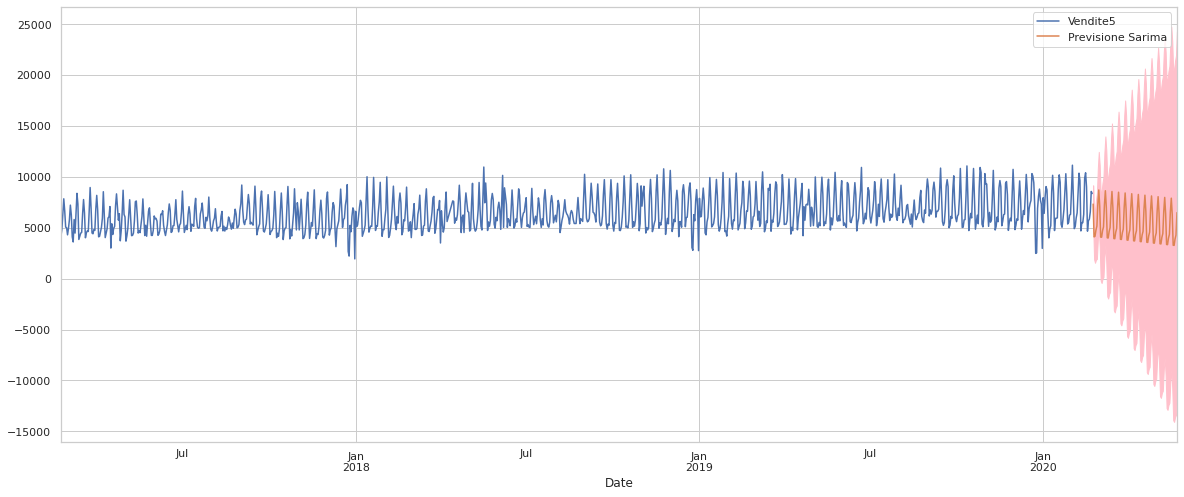

In [ ]:
data['Vendite5'].plot(figsize=(20,8), legend=True)
pred_plot= previs.plot(legend=True)
pred_plot.fill_between(confidenza.index, confidenza['lower_Vendite5'], confidenza['upper_Vendite5'], color='pink')

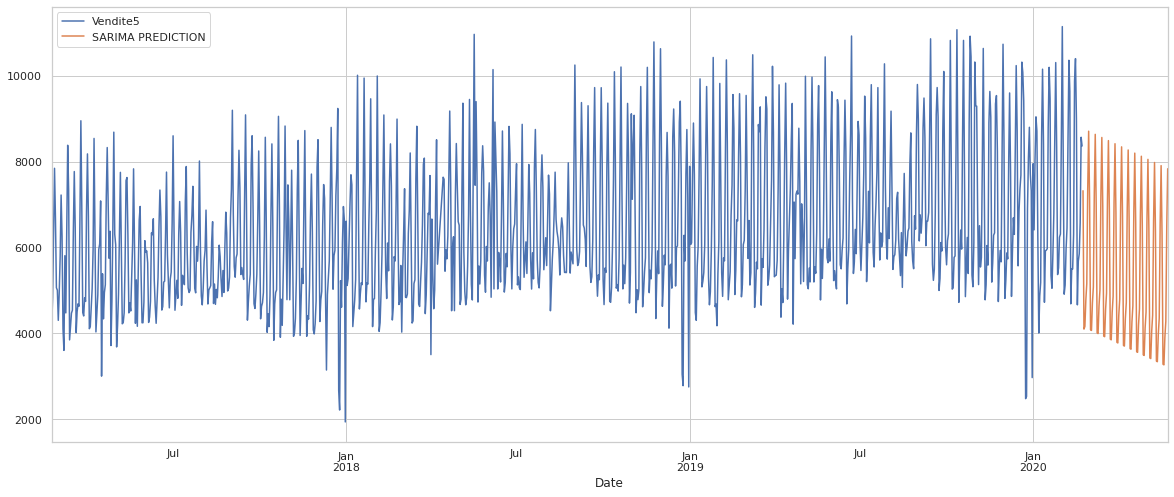

In [ ]:
predizione_nel_futuro = res.predict(len(data), len(data)+90, typ='levels').rename('SARIMA PREDICTION')
data['Vendite5'].plot(figsize=(20,8), legend=True)
predizione_nel_futuro.plot(legend=True)

---

# 6 Modello SARIMAX


In [ ]:
data

Vendite1  Vendite2  Vendite3  Vendite4  Vendite5  Vendite6  Holiday
Date                                                                           
2017-02-22   3646.42   6483.67      0.23   3009.98   4178.84      4.54        0
2017-02-23   3995.17   6467.24      0.23   2369.06   4827.18      4.54        0
2017-02-24   5290.64   8543.29      0.23   3134.82   6299.21      4.54        0
2017-02-25   9718.05  11357.02      0.23   3484.04   7844.38      4.54        0
2017-02-26   7810.37   9391.22      0.23   2442.50   6662.84      4.54        0
...              ...       ...       ...       ...       ...       ...      ...
2020-02-18   3474.67   6137.98   5511.76   3868.31   5682.64   5250.52        0
2020-02-19   3909.77   7091.73   5319.21   3786.22   5853.32   5135.10        0
2020-02-20   4491.60   7935.56   6880.10   4433.02   6578.98   6052.17        0
2020-02-21   6566.87   9419.02   7459.44   4375.96   8567.21   8179.11        0
2020-02-22   8489.01   8152.13   7072.58   3627.30   8363.68   6809.10        0

[1096 rows x 7 columns]

We check for the correct assignment of the exogenous variable.

In [ ]:
data['Holiday']['2019-01'].head(16)

Date
2019-01-01    1
2019-01-02    1
2019-01-03    1
2019-01-04    1
2019-01-05    1
2019-01-06    1
2019-01-07    0
2019-01-08    0
2019-01-09    0
2019-01-10    0
2019-01-11    0
2019-01-12    0
2019-01-13    0
2019-01-14    0
2019-01-15    0
2019-01-16    0
Freq: D, Name: Holiday, dtype: int64

## 6.1 SARIMAX ristorante 4

We visualize the vacation periods: Christmas holiday, Easter holidays and summer holidays.

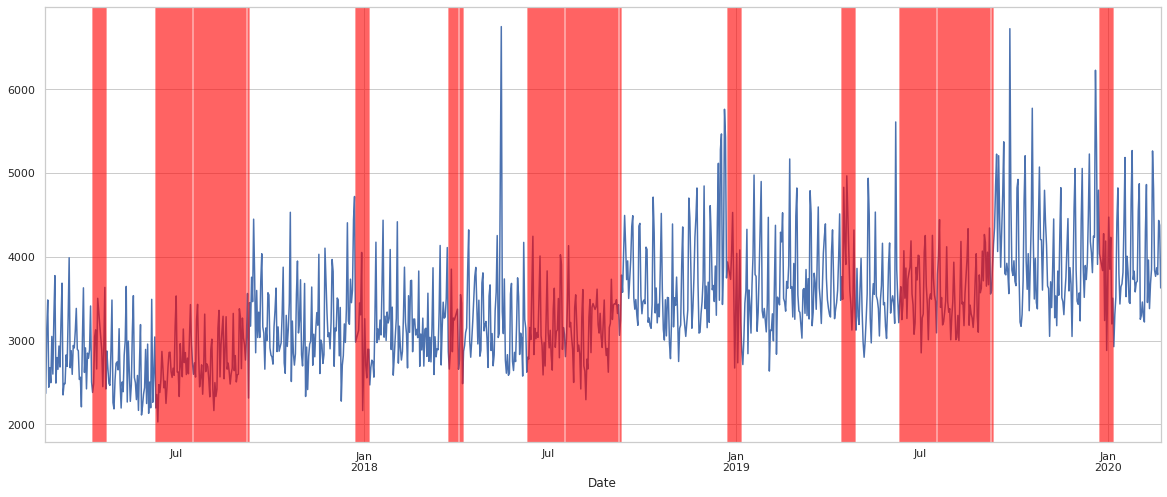

In [ ]:
ax = data['Vendite4'].plot(figsize=(20,8))
for day in data[data['Holiday'] == 1].index:
  ax.axvline(x = day, color='Red', alpha=0.5)


We execute the auto-arima again but considering the exogenous variable.

In [ ]:
auto_arima(data['Vendite4'], exogenous=data[['Holiday']], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -8094.542
Date:                             Thu, 20 Jan 2022   AIC                          16205.084
Time:                                     15:48:37   BIC                          16245.072
Sample:                                 02-22-2017   HQIC                         16220.215
                                      - 02-22-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.2091      1.213     -1.822      0.068      -4.586       0.167
Holiday     -219.1071     86.373     -2.537      0.011    -388.395     -49.819
ar.L1         -0.6056      0.018    -33.187      0.000      -0.641      -0.570
ar.L2         -0.4342      0.022    -19.964      0.000      -0.477      -0.392
ar.L3         -0.2627      0.025    -10.428      0.000      -0.312      -0.213
ar.S.L7        0.9921      0.004    253.760      0.000       0.984       1.000
ma.S.L7       -0.8934      0.022    -41.298      0.000      -0.936      -0.851
sigma2      1.642e+05   4408.287     37.242      0.000    1.56e+05    1.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1807.58
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

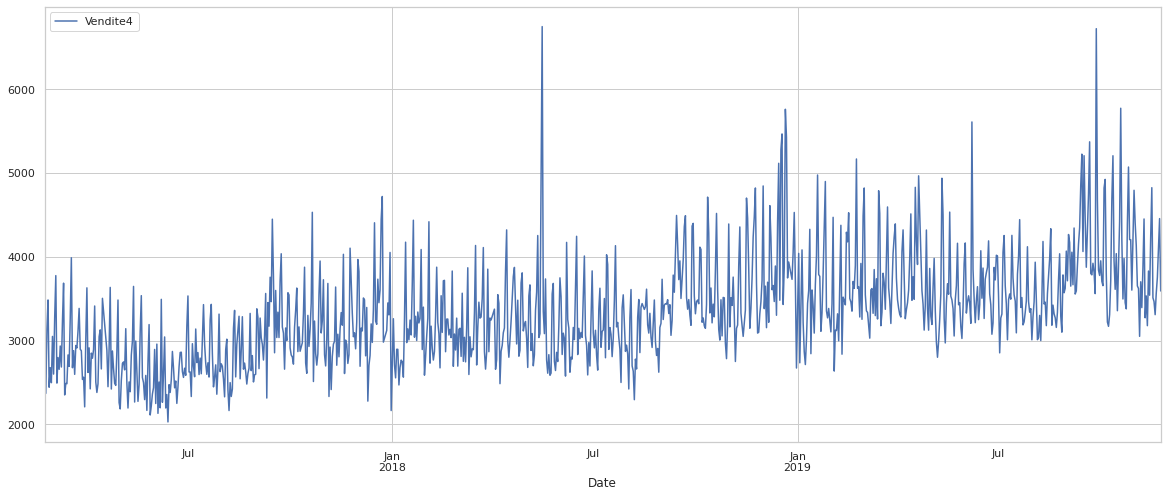

In [ ]:
len(train)
train['Vendite4'].plot(figsize=(20,8), legend=True)

We train the model and then predict.

In [ ]:
modello=SARIMAX(train['Vendite4'], exog=train[['Holiday']], order=(3,1,0), seasonal_order=(1,0,[1],7))
res = modello.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite4   No. Observations:                 1006
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -7416.782
Date:                             Thu, 20 Jan 2022   AIC                          14847.564
Time:                                     15:48:43   BIC                          14881.953
Sample:                                 02-22-2017   HQIC                         14860.631
                                      - 11-24-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday     -234.8713    4.8e-07  -4.89e+08      0.000    -234.871    -234.871
ar.L1         -0.5681      0.018    -30.742      0.000      -0.604      -0.532
ar.L2         -0.4206      0.021    -19.668      0.000      -0.463      -0.379
ar.L3         -0.2272      0.026     -8.734      0.000      -0.278      -0.176
ar.S.L7        1.0000   2.65e-05   3.78e+04      0.000       1.000       1.000
ma.S.L7       -0.9991      0.027    -37.682      0.000      -1.051      -0.947
sigma2      1.567e+05   1.71e-07   9.16e+11      0.000    1.57e+05    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):              1605.67
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+28. Standard errors may be unstable.
"""

In [ ]:
pre = res.predict(start, end, exog=test[['Holiday']]).rename('Sarimax con var esogena')

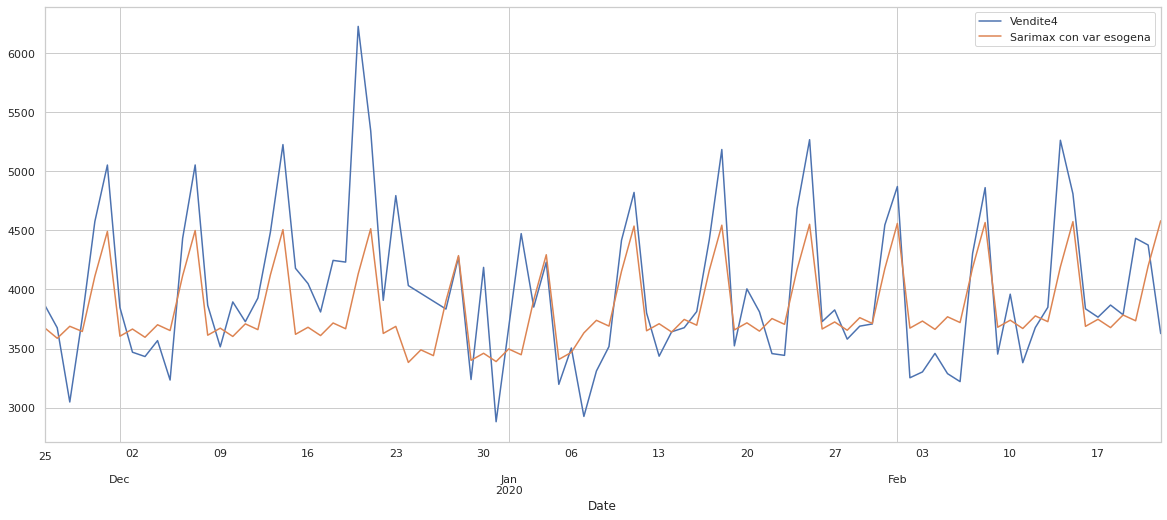

In [ ]:
test['Vendite4'].plot(legend = True)
pre.plot(figsize=(20,8), legend=True)


We evaluate the model.

In [ ]:
errore = rmse(test['Vendite4'], pre )
errore


466.0324398071956

In [ ]:
test['Vendite4'].mean()

3984.299444444444

*This model does not improve the original SARIMA model so we don't proceed.*

## 6.2 SARIMAX ristorante 5

We plot the time series over the vacation period given by the exogenous variable.

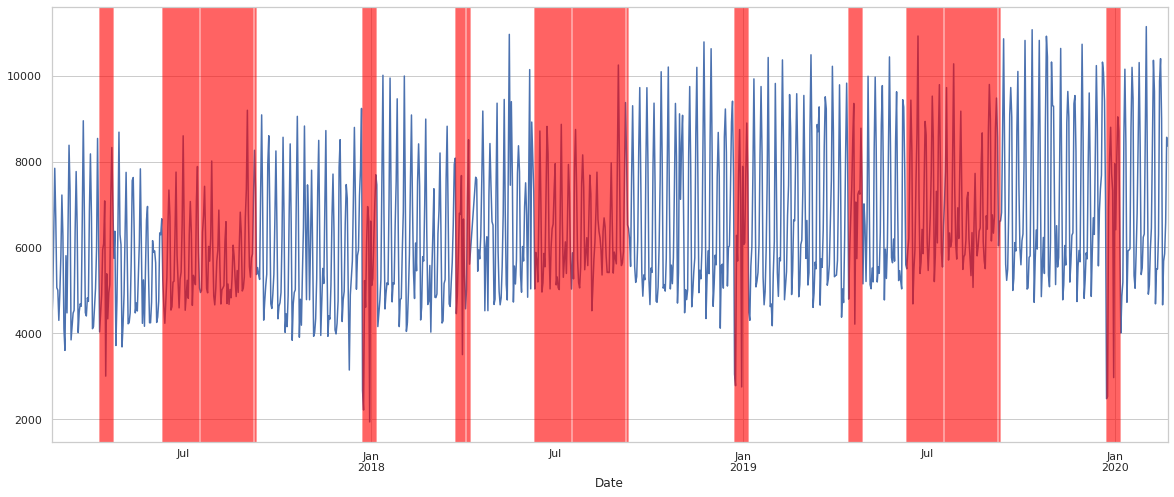

In [ ]:
ax = data['Vendite5'].plot(figsize=(20,8))
for day in data[data['Holiday'] == 1].index:
  ax.axvline(x = day, color='Red', alpha=0.5)

We look for the parameters considerning the new variable and we train the model.

In [ ]:
auto_arima(data['Vendite5'], exogenous=data[['Holiday']], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -9078.090
Date:                             Thu, 20 Jan 2022   AIC                          18168.179
Time:                                     15:51:05   BIC                          18198.171
Sample:                                 02-22-2017   HQIC                         18179.528
                                      - 02-22-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3300      5.904      1.750      0.080      -1.243      21.903
Holiday     -966.0152    121.793     -7.932      0.000   -1204.725    -727.306
ar.L1         -0.3955      0.021    -18.867      0.000      -0.437      -0.354
ar.S.L7        0.9765      0.005    195.154      0.000       0.967       0.986
ma.S.L7       -0.7554      0.022    -33.949      0.000      -0.799      -0.712
sigma2      9.579e+05   2.53e+04     37.824      0.000    9.08e+05    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.64   Jarque-Bera (JB):               920.45
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

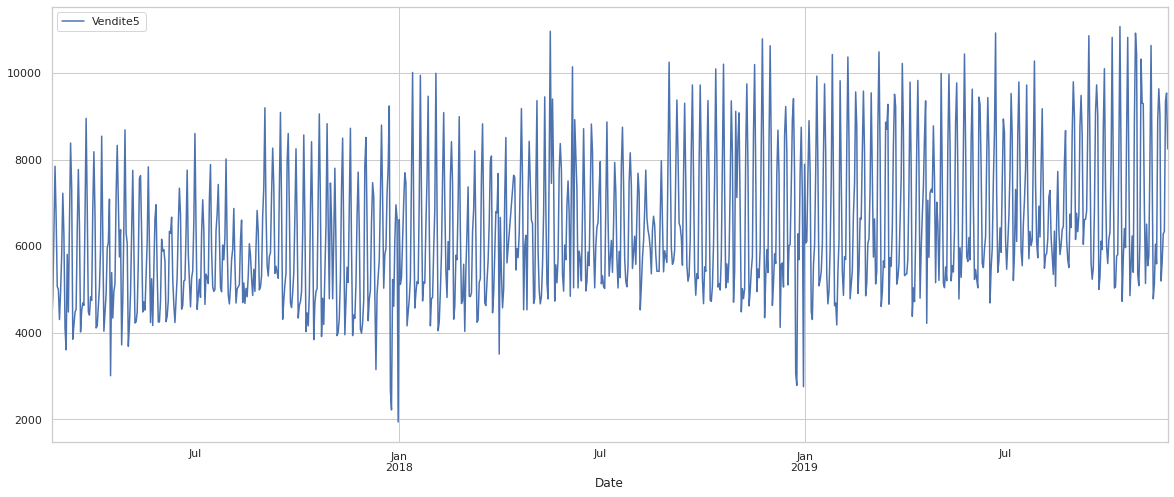

In [ ]:
len(train)
train['Vendite5'].plot(figsize=(20,8), legend=True)

In [ ]:
modello=SARIMAX(train['Vendite5'], exog=train[['Holiday']], order=(1,1,0), seasonal_order=(1,0,[1],7))
res = modello.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Vendite5   No. Observations:                 1006
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -8312.819
Date:                             Thu, 20 Jan 2022   AIC                          16635.638
Time:                                     15:49:54   BIC                          16660.202
Sample:                                 02-22-2017   HQIC                         16644.972
                                      - 11-24-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday     -934.5988      2e-07  -4.67e+09      0.000    -934.599    -934.599
ar.L1         -0.3330      0.022    -15.070      0.000      -0.376      -0.290
ar.S.L7        1.0000   1.54e-05   6.48e+04      0.000       1.000       1.000
ma.S.L7       -0.9979      0.017    -60.006      0.000      -1.030      -0.965
sigma2      8.601e+05   6.64e-09   1.29e+14      0.000     8.6e+05     8.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.41   Jarque-Bera (JB):               762.36
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.31
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+29. Standard errors may be unstable.
"""

We predict and plot the results.

In [ ]:
pre = res.predict(start, end, exog=test[['Holiday']]).rename('Sarimax con var esogena')

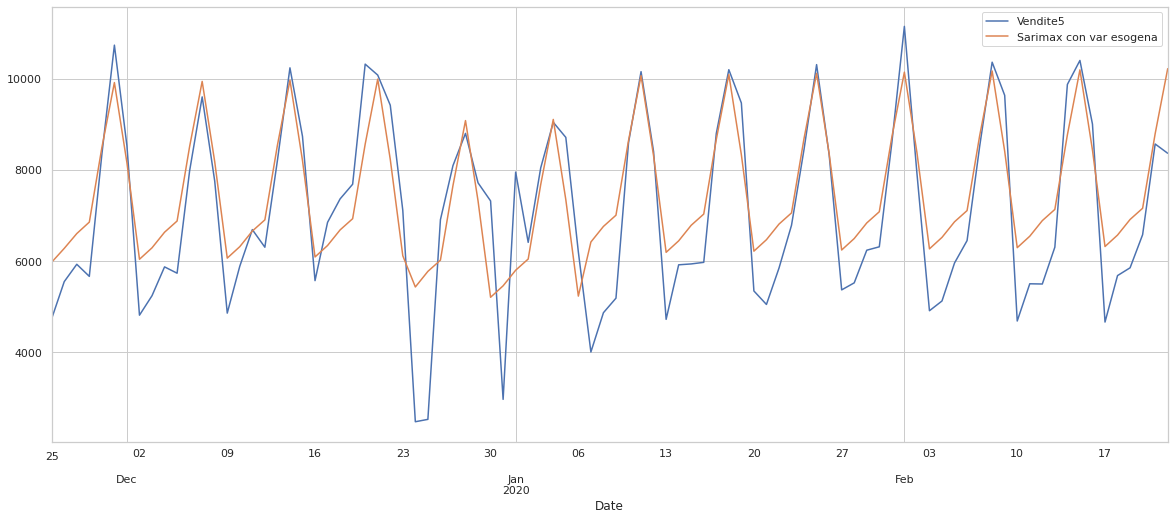

In [ ]:
test['Vendite5'].plot(legend = True)
pre.plot(figsize=(20,8), legend=True)

At last, We evaluate the model.

In [ ]:
errore = rmse(test['Vendite5'], pre )
errore

1091.2787310157

*As for Restaurant 4 the model does not provide better performance than the SARIMA model, so We do not proceed in the analysis.*

# 7 Modello Prophet

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638745 sha256=434dc9b0624ae91aec899a05f7a4cb6fa88638f27fe5af5b01bc144539d6e61c
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from prophet import Prophet
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_plotly, plot_components_plotly

We first set the periods of interest for our analysis.

In [ ]:
START = '2018-02-01'
END = '2020-02-01'
TRAIN_END = '2019-12-01'
TEST_END = '2020-02-01'
FORECAST_END = '2020-05-01'

## Prophet restaurant 4

In [ ]:
TARGET = 'Vendite4'

We then reset the index of the previously processed DataFrame, as to make it compatible with Prophet.

In [ ]:
df = ds_risto.reset_index()

In [ ]:
df = df[(df['Date'] <= END) & (df['Date'] >= START)]

We also rename the columns so that they're compatible with Prophet and then we split in train and test according to the predefined parameters (we take the whole dataset as test just to visualize training points too).

In [ ]:
df = df[['Date', TARGET]]
df.rename(columns={'Date': 'ds', TARGET: 'y'}, inplace=True)
df.fillna(0, inplace=True) # filling nan values with 0
df_train = df[df['ds'] <= TRAIN_END][['ds', 'y']]
df_test = df[['ds']]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We initialize a Prophet model.

In [ ]:
model = Prophet(yearly_seasonality=True) # Setting yearly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5) # Setting monthly seasonality
model.add_country_holidays(country_name='IT') # Setting italian holidays
model.fit(df_train) # Training the model
test = model.predict(df_test) # Getting prediction on dataset

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
model.train_holiday_names

0                    Capodanno
1         Epifania del Signore
2       Pasqua di Resurrezione
3           Lunedì dell'Angelo
4      Festa della Liberazione
5         Festa dei Lavoratori
6       Festa della Repubblica
7     Assunzione della Vergine
8                Tutti i Santi
9        Immacolata Concezione
10                      Natale
11               Santo Stefano
dtype: object

In [ ]:
test.head()

ds        trend  ...  multiplicative_terms_upper         yhat
0 2018-02-01  3146.414070  ...                         0.0  2924.357160
1 2018-02-02  3147.681694  ...                         0.0  3449.773508
2 2018-02-03  3148.949318  ...                         0.0  3774.576199
3 2018-02-04  3150.216942  ...                         0.0  2821.895257
4 2018-02-05  3151.484566  ...                         0.0  2781.717313

[5 rows x 61 columns]

We plot the model's predictions on the entire dataset, dots indicate the dataset values (they're not present for testing period).

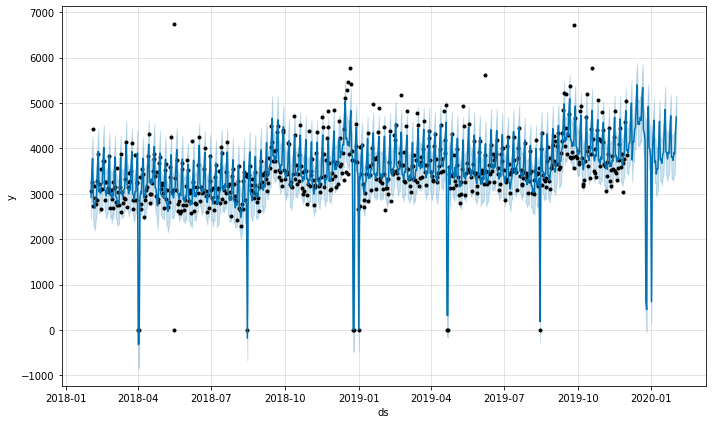

In [ ]:
fig1 = model.plot(test, uncertainty=True)

Also plotting the components.

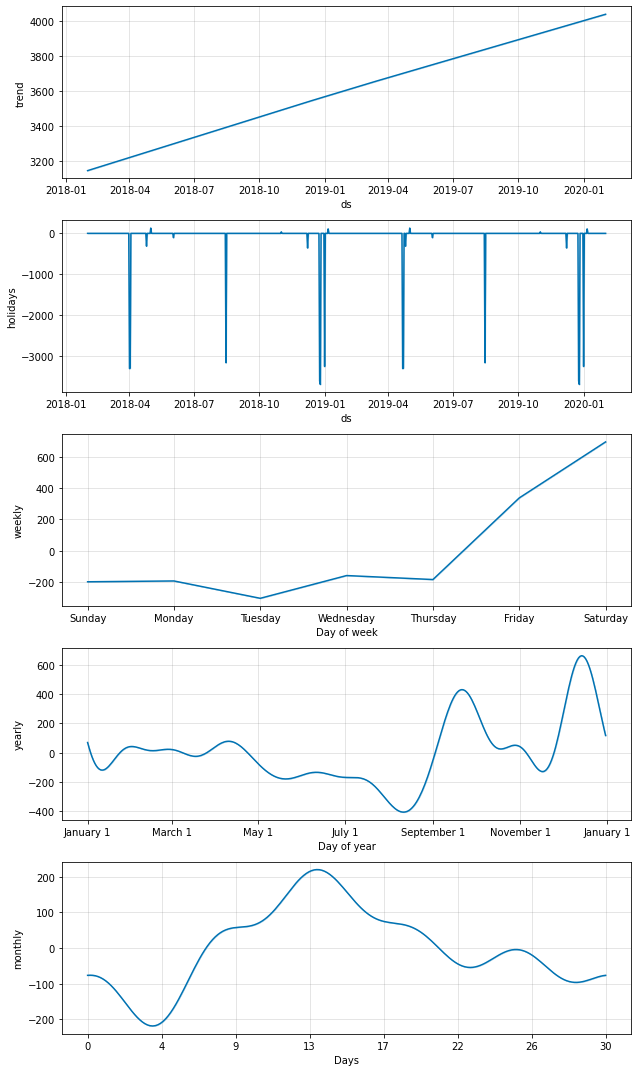

In [ ]:
fig2 = model.plot_components(test)

Then, we compute the Root Mean Squared Error only on the testset values.

In [ ]:
df_eval = df[(df['ds'] <= TEST_END) & (df['ds'] >= TRAIN_END)]
y_true = df['y'].values
y_pred = test['yhat'].values

In [ ]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 386.2869706184589


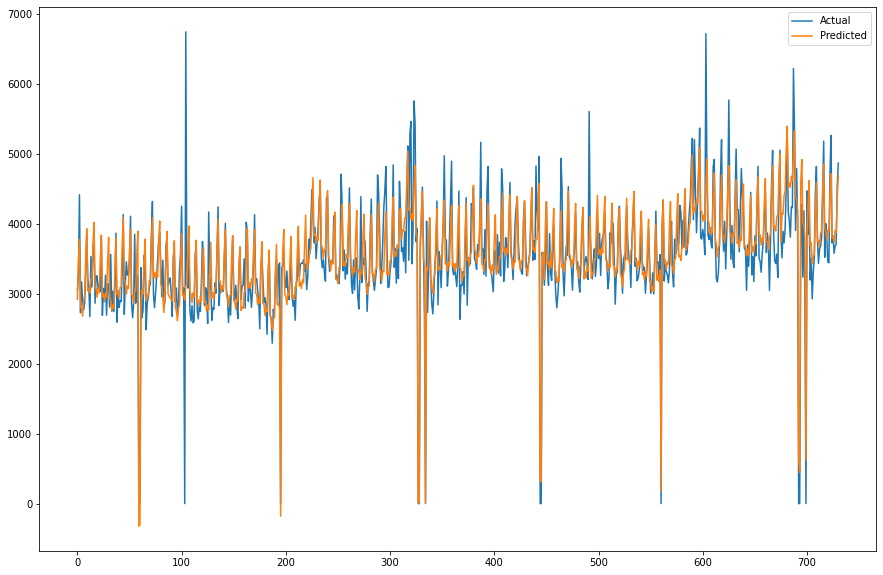

In [ ]:
# Faccio il plot dei valori reali con quelli predetti (test)
pyplot.figure(figsize=(15, 10))
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

We generate dates in the future (points not belonging to the original dataset) so that we can get the model's forecast on it.

In [ ]:
df_future = pd.DataFrame(pd.date_range(start=TEST_END, end=FORECAST_END), columns=['ds'])

In [ ]:
forecast = model.predict(df_future) # forecasting the future

In [ ]:
forecast.head()

ds        trend  ...  multiplicative_terms_upper         yhat
0 2020-02-01  4039.369155  ...                         0.0  4689.598214
1 2020-02-02  4040.549981  ...                         0.0  3790.605031
2 2020-02-03  4041.730808  ...                         0.0  3810.042237
3 2020-02-04  4042.911634  ...                         0.0  3702.639189
4 2020-02-05  4044.092461  ...                         0.0  3814.110072

[5 rows x 61 columns]

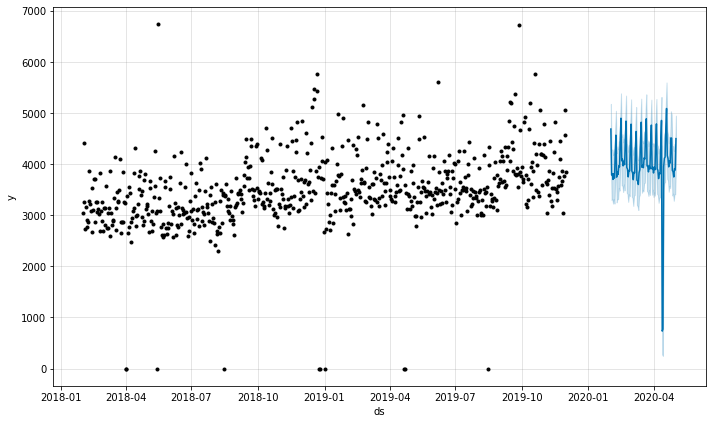

In [ ]:
# Plotting the forecast in the future.
fig3 = model.plot(forecast, uncertainty=True)

(737456.0, 737546.0)

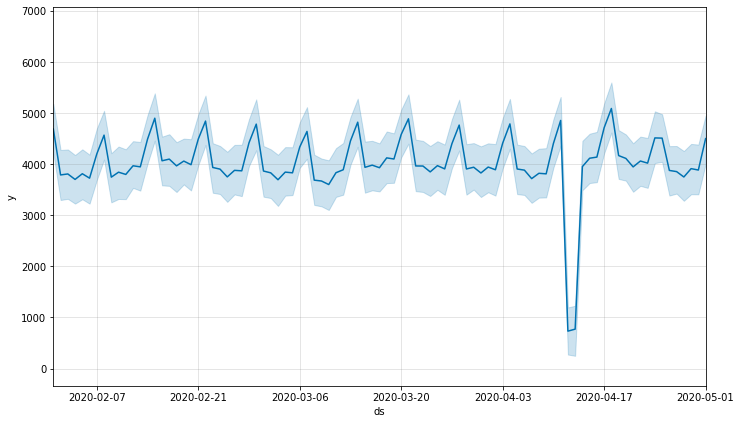

In [ ]:
# Plotting the forecast in the future period only.
fig4 = model.plot(forecast, uncertainty=True)
ax = fig4.gca()
ax.set_xlim(pd.to_datetime([TEST_END, FORECAST_END])) # limito la vista solo sul periodo futuro

## Prophet ristorante 5

We now repeat the same steps for Restaurant number 5

In [ ]:
TARGET = 'Vendite5'

In [ ]:
df = ds_risto.reset_index()

In [ ]:
df = df[(df['Date'] <= END) & (df['Date'] >= START)]

In [ ]:
df = df[['Date', TARGET]]
df.rename(columns={'Date': 'ds', TARGET: 'y'}, inplace=True)
df.fillna(0, inplace=True)
df_train = df[df['ds'] <= TRAIN_END][['ds', 'y']]
df_test = df[['ds']]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model = Prophet(yearly_seasonality=True) # Setto la stagionalità annuale
model.add_seasonality(name='monthly', period=30.5, fourier_order=5) # Setto la stagionalità mensile
model.add_country_holidays(country_name='IT') # Setto i giorni festivi dal calendario italiano
model.fit(df_train) # Training del modello
test = model.predict(df_test) # Predizione sul testset

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
model.train_holiday_names

0                    Capodanno
1         Epifania del Signore
2       Pasqua di Resurrezione
3           Lunedì dell'Angelo
4      Festa della Liberazione
5         Festa dei Lavoratori
6       Festa della Repubblica
7     Assunzione della Vergine
8                Tutti i Santi
9        Immacolata Concezione
10                      Natale
11               Santo Stefano
dtype: object

In [ ]:
test.head()

ds        trend  ...  multiplicative_terms_upper         yhat
0 2018-02-01  5934.895637  ...                         0.0  5097.963683
1 2018-02-02  5937.284940  ...                         0.0  6958.974340
2 2018-02-03  5939.674242  ...                         0.0  8634.346152
3 2018-02-04  5942.063545  ...                         0.0  7024.758824
4 2018-02-05  5944.452848  ...                         0.0  4424.632962

[5 rows x 61 columns]

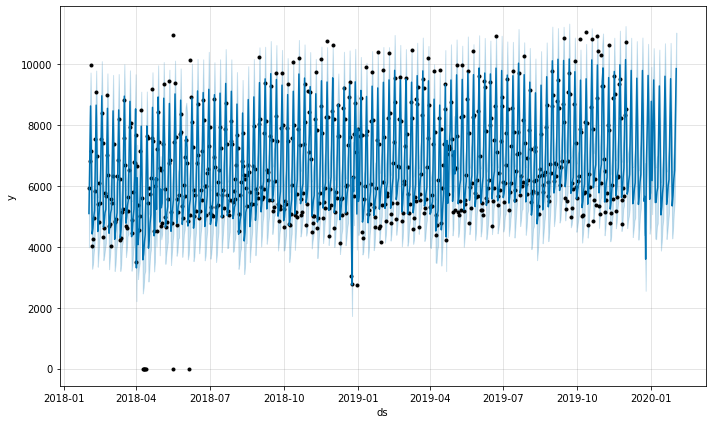

In [ ]:
fig1 = model.plot(test, uncertainty=True)

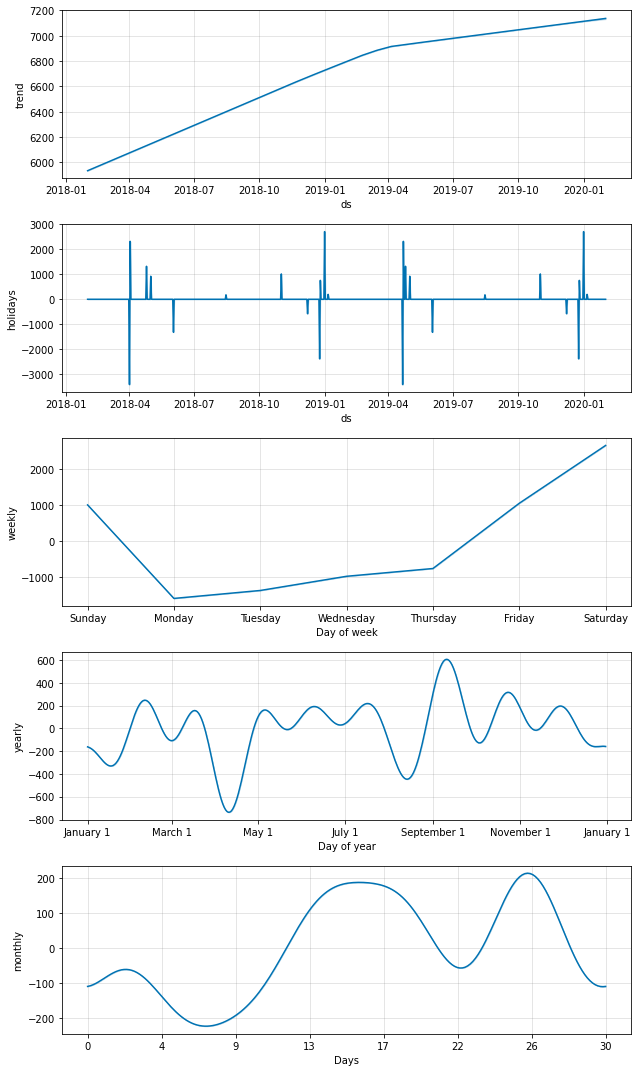

In [ ]:
fig2 = model.plot_components(test)

In [ ]:
df_eval = df[(df['ds'] <= TEST_END) & (df['ds'] >= TRAIN_END)]
y_true = df['y'].values
y_pred = test['yhat'].values

In [ ]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 875.9001535689476


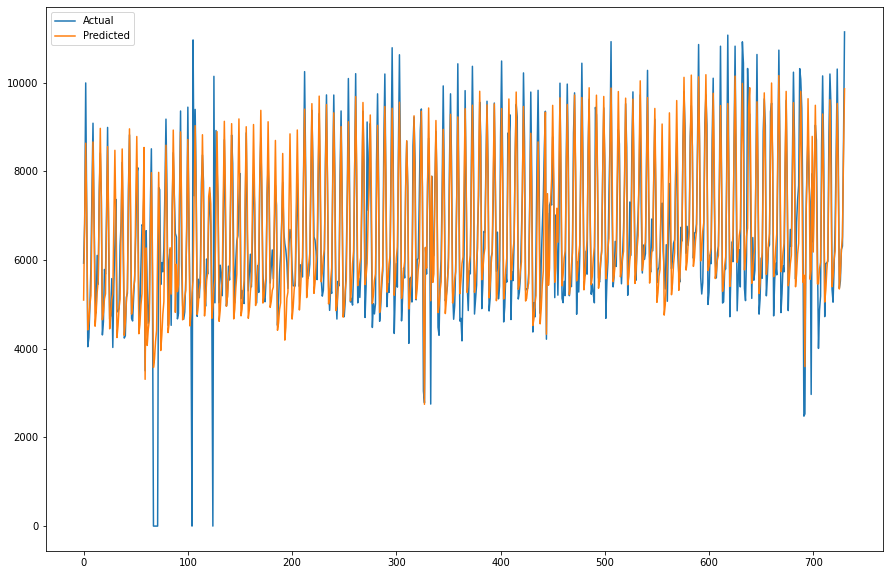

In [ ]:
pyplot.figure(figsize=(15, 10))
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
df_future = pd.DataFrame(pd.date_range(start=TEST_END, end=FORECAST_END), columns=['ds'])

In [ ]:
forecast = model.predict(df_future)

In [ ]:
forecast.head()

ds        trend  ...  multiplicative_terms_upper         yhat
0 2020-02-01  7137.040521  ...                         0.0  9862.698142
1 2020-02-02  7137.770080  ...                         0.0  8141.719342
2 2020-02-03  7138.499638  ...                         0.0  5524.734251
3 2020-02-04  7139.229197  ...                         0.0  5787.115448
4 2020-02-05  7139.958755  ...                         0.0  6243.098462

[5 rows x 61 columns]

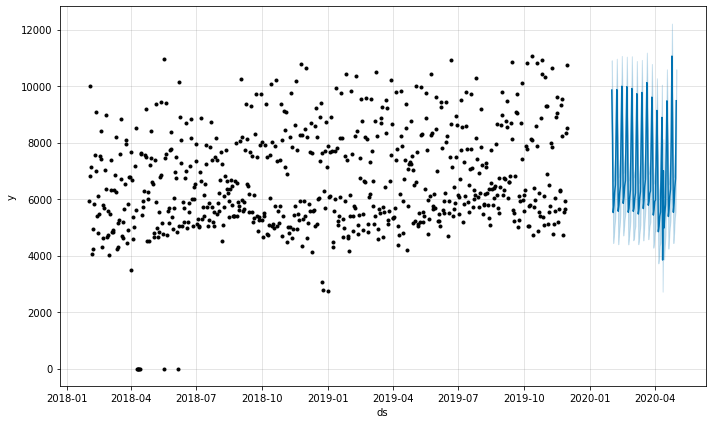

In [ ]:
fig3 = model.plot(forecast, uncertainty=True)

(737456.0, 737546.0)

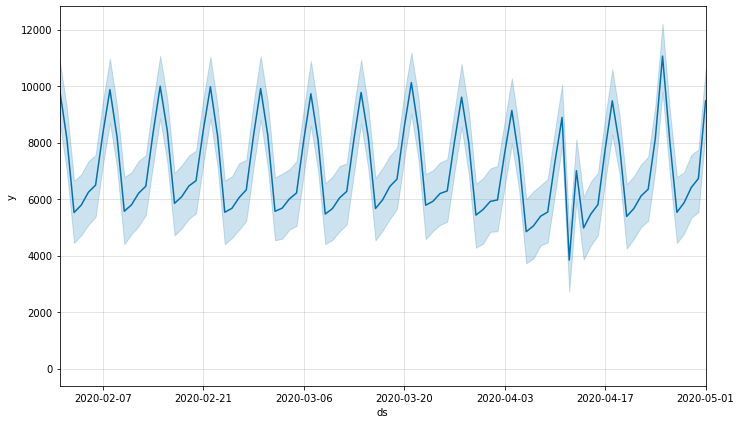

In [ ]:
fig4 = model.plot(forecast, uncertainty=True)
ax = fig4.gca()
ax.set_xlim(pd.to_datetime([TEST_END, FORECAST_END]))